## Christopher O'Brien Homework 4 CSC 380 PROJECT

# 1 Setup
## 1.1 Dataset Selection

<font color=green>I chose NF-UNSW-NB15-v2 which is the network flow data from network intrusion detection systems at https://staff.itee.uq.edu.au/marius/NIDS_datasets/#RA6 <BR> A description is here https://research.unsw.edu.au/projects/unsw-nb15-dataset </font>

## 1.2 Github Setup

<font color=green>https://github.com/CSC380-SU23-UofArizona/final-project-chr211/blob/main/README.md</font>

# 2 Data Collection [5 points]
## 2.1 Dataset Description

<font color=green> The data was collected at the Cyber Range at the University of Canaberra with TCPdump along with Argus, Bro-IDS tools for the purposes of identifying malicious network traffic. There are 7 types of traffic categorized with one being benign, the others are attacks of either Fuzzers, Analysis, Backdoors, DoS, Exploits, Generic, Reconnaissance, Shellcode and Worms. It has 2390275 rows of data, some duplicated. 45 features total are available like packet size, IP SRC address, ports etc. Some features contribute more than others to the attack type and this is what I am going to investigate. You'll notice that I will have 2 datasets, datasample and no_benign_df, datasample includes rows with benign network traffic, while no_benign does not, otherwise they are similar.</font> <BR><BR><font color=green>Each type of attack has a different network footprint or signature in theory and practice. Software usually runs on standard network port numbers and this helps ID some types of attacks. Also, certain backdoor attacks also may be associated with a set range of ports. The port activity alone cannot be an indicator of an attack, there also needs to be an identification and classification of data flow on that port and the source port and IP address. The dataset has 44 network variables that can be correlated and analyzed to associate them together with the type of attack in that row. Each type of attack will have some common variables and behavior which can be generalized by a machine learning model which can then predict the type of attack given 44 new test variables. The benign data represents the largest amount of data in this set and is good to establish a baseline of normal behavior, this may however, increase the amount of false negatives since the benign data might have large variance.This data set is composed of both normal and "synthesized" attacks and was created over period of time in 2015. It has not been formally updated, but there are several variants created in the same time frame and listed on the source page.</font> <BR><BR><font color=green> It is important to note that I only take a sample of the entire data set because of the time for the machine learning model to process it becomes too long (especially for the one grading this). Therefore, I take a random sample of a reasonable size. This means that the null/NAN and duplicated data etc. changes each run. This is not a problem as the method to deal with this data is the same each time.</font>

<font color=green>Load libraries first</font>

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from scipy.stats import chi2_contingency
from scipy.stats import zscore

import pandas as pd
import numpy as np

from sklearn.neural_network import MLPClassifier

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

from sklearn.ensemble import IsolationForest
from sklearn.ensemble import RandomForestClassifier 

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import silhouette_score, r2_score
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler


from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans


from sklearn.svm import SVC


from sklearn.feature_selection import f_regression
from sklearn.model_selection import train_test_split


## 2.2 Dataset Download

In [2]:
data = pd.read_csv('NF-UNSW-NB15-v2.csv')
datasample = data.sample(50000).copy() #50k is a reasonable size for processing on my laptop. Other platforms can use the entire set in a reasonable time.

no_benign_df = data[data['Attack'] != 'Benign'].sample(75000)# Similar to set above, but with no Benign network data.

<font color=green>Load both data sets with a subset of data from the 2390275 row source</font>


In [3]:
datasample.reset_index(inplace=True)
no_benign_df.reset_index(inplace=True)

Since it's a sample, the indices will be random, reset to ordered index.

# 3 Data Preprocessing [20 points]
# 3.1 Data cleaning

### 1. Perform some initial data exploration to understand the dataset better.

Size of the data set in rows and features (included potential target label)

In [4]:
data.shape

(2390275, 45)

In [5]:
(data['Attack'] == 'Benign').sum()

2295222

Benign data was approximately 96% of total data

In [6]:
data.sample()

,IPV4_SRC_ADDR,L4_SRC_PORT,IPV4_DST_ADDR,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,...,TCP_WIN_MAX_IN,TCP_WIN_MAX_OUT,ICMP_TYPE,ICMP_IPV4_TYPE,DNS_QUERY_ID,DNS_QUERY_TYPE,DNS_TTL_ANSWER,FTP_COMMAND_RET_CODE,Label,Attack
756371,59.166.0.9,1637,149.171.126.5,53,17,0.0,146,2,178,2,...,0,0,0,0,41920,1,60,0.0,0,Benign


<font color=green>Check for null values:</font>

In [7]:
datasample.isna().sum()

index                          0
IPV4_SRC_ADDR                  0
L4_SRC_PORT                    0
IPV4_DST_ADDR                  0
L4_DST_PORT                    0
PROTOCOL                       0
L7_PROTO                       0
IN_BYTES                       0
IN_PKTS                        0
OUT_BYTES                      0
OUT_PKTS                       0
TCP_FLAGS                      0
CLIENT_TCP_FLAGS               0
SERVER_TCP_FLAGS               0
FLOW_DURATION_MILLISECONDS     0
DURATION_IN                    0
DURATION_OUT                   0
MIN_TTL                        0
MAX_TTL                        0
LONGEST_FLOW_PKT               0
SHORTEST_FLOW_PKT              0
MIN_IP_PKT_LEN                 0
MAX_IP_PKT_LEN                 0
SRC_TO_DST_SECOND_BYTES        0
DST_TO_SRC_SECOND_BYTES        0
RETRANSMITTED_IN_BYTES         0
RETRANSMITTED_IN_PKTS          0
RETRANSMITTED_OUT_BYTES        0
RETRANSMITTED_OUT_PKTS         0
SRC_TO_DST_AVG_THROUGHPUT      0
DST_TO_SRC

<BR><font color=green>Nulls will be listed above and I will remove them below.</font>

In [8]:
no_benign_df.isna().sum()

index                          0
IPV4_SRC_ADDR                  0
L4_SRC_PORT                    0
IPV4_DST_ADDR                  0
L4_DST_PORT                    0
PROTOCOL                       0
L7_PROTO                       0
IN_BYTES                       0
IN_PKTS                        0
OUT_BYTES                      0
OUT_PKTS                       0
TCP_FLAGS                      0
CLIENT_TCP_FLAGS               0
SERVER_TCP_FLAGS               0
FLOW_DURATION_MILLISECONDS     0
DURATION_IN                    0
DURATION_OUT                   0
MIN_TTL                        0
MAX_TTL                        0
LONGEST_FLOW_PKT               0
SHORTEST_FLOW_PKT              0
MIN_IP_PKT_LEN                 0
MAX_IP_PKT_LEN                 0
SRC_TO_DST_SECOND_BYTES        0
DST_TO_SRC_SECOND_BYTES        0
RETRANSMITTED_IN_BYTES         0
RETRANSMITTED_IN_PKTS          0
RETRANSMITTED_OUT_BYTES        0
RETRANSMITTED_OUT_PKTS         0
SRC_TO_DST_AVG_THROUGHPUT      0
DST_TO_SRC

In [9]:
datasample.dropna(inplace=True)
no_benign_df.dropna(inplace=True)

<font color=green>I can use datasample.dropna() to drop all rows with NAN.</font>

In [10]:
datasample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 46 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   index                        50000 non-null  int64  
 1   IPV4_SRC_ADDR                50000 non-null  object 
 2   L4_SRC_PORT                  50000 non-null  int64  
 3   IPV4_DST_ADDR                50000 non-null  object 
 4   L4_DST_PORT                  50000 non-null  int64  
 5   PROTOCOL                     50000 non-null  int64  
 6   L7_PROTO                     50000 non-null  float64
 7   IN_BYTES                     50000 non-null  int64  
 8   IN_PKTS                      50000 non-null  int64  
 9   OUT_BYTES                    50000 non-null  int64  
 10  OUT_PKTS                     50000 non-null  int64  
 11  TCP_FLAGS                    50000 non-null  int64  
 12  CLIENT_TCP_FLAGS             50000 non-null  int64  
 13  SERVER_TCP_FLAGS

<font color=green>Looking at the data types, I see mostly integer values, but a few object and float values too. The last feature 'Attack' is the category of attack that I would like to predict given the rest of the data. I will convert the value to an integer using a labelencoder and feed it into the machine learning model as a dependent variable.</font>



In [11]:
datasample['Attack'].unique()

array(['Benign', 'Generic', 'Exploits', 'Fuzzers', 'DoS', 'Analysis',
       'Reconnaissance', 'Backdoor', 'Shellcode', 'Worms'], dtype=object)

<BR><font color=green>These are the types of attack classes. The Exploits type is always near the top behind benign and worms are the rarest.</font>

In [12]:
datasample['Attack'].value_counts()

Attack
Benign            48126
Exploits            608
Fuzzers             440
Generic             340
Reconnaissance      252
DoS                 110
Analysis             48
Backdoor             43
Shellcode            31
Worms                 2
Name: count, dtype: int64

In [13]:
no_benign_df['Attack'].value_counts()

Attack
Exploits          24811
Fuzzers           17694
Generic           13093
Reconnaissance    10067
DoS                4582
Analysis           1765
Backdoor           1743
Shellcode          1112
Worms               133
Name: count, dtype: int64


Examples of two different feature's value spread

In [14]:
datasample['FTP_COMMAND_RET_CODE'].value_counts()

FTP_COMMAND_RET_CODE
0.0      40872
125.0     2734
229.0     2666
230.0     1826
331.0      914
221.0      908
227.0       32
150.0       23
213.0       19
226.0        3
220.0        1
200.0        1
250.0        1
Name: count, dtype: int64

In [15]:
datasample['L7_PROTO'].value_counts()

L7_PROTO
0.000      31824
1.000      10047
7.000       4360
3.000       1639
4.000        988
92.000       973
17.000        45
13.000        28
41.000        23
131.700       14
139.000        9
127.000        7
20.000         6
77.000         6
96.000         5
78.000         4
161.000        4
2.000          4
100.000        2
7.131          2
164.000        1
89.000         1
114.000        1
125.380        1
132.000        1
167.000        1
19.000         1
111.000        1
10.000         1
79.000         1
Name: count, dtype: int64

<font color=green>Next, I will normalize the floating point values and round then to integers since they are only integers anyhow as seen above.</font>


In [16]:
datasample[['L7_PROTO','FTP_COMMAND_RET_CODE','SRC_TO_DST_SECOND_BYTES','DST_TO_SRC_SECOND_BYTES']] = datasample[['L7_PROTO','FTP_COMMAND_RET_CODE','SRC_TO_DST_SECOND_BYTES','DST_TO_SRC_SECOND_BYTES']].astype('int64')

In [17]:
no_benign_df[['L7_PROTO','FTP_COMMAND_RET_CODE','SRC_TO_DST_SECOND_BYTES','DST_TO_SRC_SECOND_BYTES']] = no_benign_df[['L7_PROTO','FTP_COMMAND_RET_CODE','SRC_TO_DST_SECOND_BYTES','DST_TO_SRC_SECOND_BYTES']].astype('int64')
datasample

,index,IPV4_SRC_ADDR,L4_SRC_PORT,IPV4_DST_ADDR,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,IN_PKTS,OUT_BYTES,...,TCP_WIN_MAX_IN,TCP_WIN_MAX_OUT,ICMP_TYPE,ICMP_IPV4_TYPE,DNS_QUERY_ID,DNS_QUERY_TYPE,DNS_TTL_ANSWER,FTP_COMMAND_RET_CODE,Label,Attack
0,64795,59.166.0.3,61939,149.171.126.8,53,17,0,132,2,164,...,0,0,0,0,21590,1,60,0,0,Benign
1,804641,59.166.0.2,37412,149.171.126.5,53,17,0,130,2,162,...,0,0,0,0,14209,1,60,0,0,Benign
2,139509,59.166.0.1,10561,149.171.126.3,6881,6,0,10476,180,395734,...,65160,27512,13824,54,0,0,0,0,0,Benign
3,710049,59.166.0.1,29037,149.171.126.9,21,6,1,1031,19,1474,...,14480,13032,64256,251,0,0,0,230,0,Benign
4,27948,59.166.0.7,62553,149.171.126.7,6881,6,0,11168,192,447154,...,65160,30408,49152,192,0,0,0,0,0,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,930253,59.166.0.4,16738,149.171.126.9,53,17,0,146,2,178,...,0,0,0,0,58567,1,60,0,0,Benign
49996,424161,59.166.0.5,33806,149.171.126.3,21,6,1,2059,37,2816,...,21720,18824,63744,249,0,0,0,125,0,Benign
49997,1792848,59.166.0.8,16883,149.171.126.9,53,17,0,146,2,178,...,0,0,0,0,58454,1,60,0,0,Benign
49998,1737233,59.166.0.6,45918,149.171.126.7,42728,6,0,4456,18,2456,...,14480,14480,5120,20,0,0,0,0,0,Benign


### 3. Apply suitable techniques to handle missing values, such as imputation or exclusion, based
### on a logical approach.

<font color=green>I should look for missing values including empty strings</font>

In [18]:
datasample[datasample.eq('').any(axis=1)]

,index,IPV4_SRC_ADDR,L4_SRC_PORT,IPV4_DST_ADDR,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,IN_PKTS,OUT_BYTES,...,TCP_WIN_MAX_IN,TCP_WIN_MAX_OUT,ICMP_TYPE,ICMP_IPV4_TYPE,DNS_QUERY_ID,DNS_QUERY_TYPE,DNS_TTL_ANSWER,FTP_COMMAND_RET_CODE,Label,Attack


In [19]:
no_benign_df[no_benign_df.eq('').any(axis=1)]

,index,IPV4_SRC_ADDR,L4_SRC_PORT,IPV4_DST_ADDR,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,IN_PKTS,OUT_BYTES,...,TCP_WIN_MAX_IN,TCP_WIN_MAX_OUT,ICMP_TYPE,ICMP_IPV4_TYPE,DNS_QUERY_ID,DNS_QUERY_TYPE,DNS_TTL_ANSWER,FTP_COMMAND_RET_CODE,Label,Attack


<font color=green>I now convert the ip address features to integers for processing later</font>

In [20]:
# Function to extract the first 4 octets and remove the periods
def IPtoInt(ip):
    octets = ip.split('.')
    first4octets = ''.join(octets[:4])
    first4octets.replace('.', '')
    return first4octets

In [21]:
datasample['IPV4_SRC_ADDR'] = datasample['IPV4_SRC_ADDR'].apply(IPtoInt).astype('int64')
no_benign_df['IPV4_SRC_ADDR'] = no_benign_df['IPV4_SRC_ADDR'].apply(IPtoInt).astype('int64')

In [22]:
datasample['IPV4_DST_ADDR'] = datasample['IPV4_DST_ADDR'].apply(IPtoInt).astype('int64')
no_benign_df['IPV4_DST_ADDR'] = no_benign_df['IPV4_DST_ADDR'].apply(IPtoInt).astype('int64')

In [23]:
no_benign_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75000 entries, 0 to 74999
Data columns (total 46 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   index                        75000 non-null  int64 
 1   IPV4_SRC_ADDR                75000 non-null  int64 
 2   L4_SRC_PORT                  75000 non-null  int64 
 3   IPV4_DST_ADDR                75000 non-null  int64 
 4   L4_DST_PORT                  75000 non-null  int64 
 5   PROTOCOL                     75000 non-null  int64 
 6   L7_PROTO                     75000 non-null  int64 
 7   IN_BYTES                     75000 non-null  int64 
 8   IN_PKTS                      75000 non-null  int64 
 9   OUT_BYTES                    75000 non-null  int64 
 10  OUT_PKTS                     75000 non-null  int64 
 11  TCP_FLAGS                    75000 non-null  int64 
 12  CLIENT_TCP_FLAGS             75000 non-null  int64 
 13  SERVER_TCP_FLAGS             75

<font color=green>Above I can see above that all the feature columns are 64 bit integers and the label attack is still an object that I will encode later.</font>

In [24]:
datasample['IPV4_SRC_ADDR'].value_counts()

IPV4_SRC_ADDR
5916601        4965
5916604        4890
5916602        4840
5916605        4757
5916600        4705
5916608        4695
5916607        4690
5916603        4676
5916606        4577
5916609        4573
175451761       640
175451760       587
175451763       584
175451762       447
14917112618      87
14917112615      44
14917112610      43
14917112614      36
14917112612      29
1491711269       14
1491711260       14
1491711265       14
1491711266       14
1491711263       13
1491711268       12
1491711264       10
1491711262        9
1491711267        9
1491711261        8
10408510          6
10401821          5
14917112611       2
14917112613       2
1040851           2
14917112617       1
Name: count, dtype: int64

<font color=green>Now I check for any invalid values. I can do this by looking at the number of unique values below. Some of these network variables have a finite range. I would need to check them against a formal reference.</font>

In [25]:
datasample.nunique()

index                          50000
IPV4_SRC_ADDR                     35
L4_SRC_PORT                    33819
IPV4_DST_ADDR                     37
L4_DST_PORT                    12862
PROTOCOL                         154
L7_PROTO                          29
IN_BYTES                        1945
IN_PKTS                          351
OUT_BYTES                       2318
OUT_PKTS                         390
TCP_FLAGS                         12
CLIENT_TCP_FLAGS                  11
SERVER_TCP_FLAGS                   9
FLOW_DURATION_MILLISECONDS        36
DURATION_IN                       36
DURATION_OUT                      23
MIN_TTL                           10
MAX_TTL                           14
LONGEST_FLOW_PKT                 678
SHORTEST_FLOW_PKT                119
MIN_IP_PKT_LEN                    20
MAX_IP_PKT_LEN                   678
SRC_TO_DST_SECOND_BYTES         1959
DST_TO_SRC_SECOND_BYTES         2423
RETRANSMITTED_IN_BYTES          1107
RETRANSMITTED_IN_PKTS            101
R

In [26]:
datasample.describe()

,index,IPV4_SRC_ADDR,L4_SRC_PORT,IPV4_DST_ADDR,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,IN_PKTS,OUT_BYTES,...,NUM_PKTS_1024_TO_1514_BYTES,TCP_WIN_MAX_IN,TCP_WIN_MAX_OUT,ICMP_TYPE,ICMP_IPV4_TYPE,DNS_QUERY_ID,DNS_QUERY_TYPE,DNS_TTL_ANSWER,FTP_COMMAND_RET_CODE,Label
count,5.000000e+04,5.000000e+04,50000.00000,5.000000e+04,50000.000000,50000.00000,50000.000000,5.000000e+04,50000.000000,5.000000e+04,...,50000.000000,50000.000000,50000.00000,50000.00000,50000.00000,50000.000000,50000.000000,5.000000e+04,50000.000000,50000.000000
mean,1.198844e+06,8.981700e+07,32674.82502,2.088495e+09,11423.653260,9.13144,2.964960,4.430261e+03,36.093900,3.592721e+04,...,24.125940,17355.200940,12194.10586,18915.15938,73.88710,5039.825560,3.846880,4.271678e+04,37.831100,0.037480
std,6.888845e+05,1.041385e+09,19167.25704,2.794700e+09,18527.568615,10.88941,13.411753,4.681877e+04,70.525794,1.552957e+05,...,105.489874,16933.167943,11006.57333,20412.89862,79.73775,13850.703876,208.679473,9.512737e+06,84.307569,0.189937
min,1.300000e+01,1.040851e+06,0.00000,2.240050e+05,0.000000,0.00000,0.000000,9.000000e+00,1.000000,0.000000e+00,...,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,6.032618e+05,5.916602e+06,15865.50000,1.491711e+09,25.000000,6.00000,0.000000,4.810000e+02,4.000000,3.120000e+02,...,0.000000,0.000000,5792.00000,0.00000,0.00000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
50%,1.202456e+06,5.916605e+06,32890.00000,1.491711e+09,80.000000,6.00000,0.000000,1.589000e+03,18.000000,2.456000e+03,...,0.000000,14480.000000,13032.00000,11008.00000,43.00000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
75%,1.797597e+06,5.916607e+06,49280.00000,1.491711e+09,15807.000000,6.00000,1.000000,3.182000e+03,44.000000,1.498800e+04,...,12.000000,24616.000000,14480.00000,33792.00000,132.00000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
max,2.390190e+06,1.491711e+10,65534.00000,1.921682e+10,65532.000000,255.00000,167.000000,9.185368e+06,6988.000000,4.606282e+06,...,5980.000000,65398.000000,65160.00000,65280.00000,255.00000,65535.000000,32769.000000,2.127108e+09,331.000000,1.000000


<font color=green>There should be no negative values, as these are not valid. I can do this with less than lt(0) in *any* rows or columns.If the result is true, I can just remove that entire row or impute the value using a similar one in another row.</font>

In [27]:
has_negative_values = datasample.drop(['Attack'], axis=1).lt(0).any().any()#drop attack since i didn't encode yet
print(has_negative_values)

False


### 4. Justify the chosen method for dealing with missing data in at least 50 words.

<font color=green>There wasn't any missing data, but if there was I would either have to impute the data given adjacent or mean values or remove the row if I could not impute. This would apply to both blank and NAN values. I changed the data so that all values where 64 bit integers for normalization purposes. I converted the IP address strings to integer values and convert floating point values to integers since there were no decimal parts in any of them. NOTE: I will normalize the features in the model training section of this paper and compare with the non normalized feature set. In theory, normalizing the data will make the classifications more accurate by reducing the values closer to 0.</font>

## 3.2 Outlier Detection

### 1. Check for outliers. You may need data visualization here. Go for a method you see fit.


In [28]:
datasample.describe()

,index,IPV4_SRC_ADDR,L4_SRC_PORT,IPV4_DST_ADDR,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,IN_PKTS,OUT_BYTES,...,NUM_PKTS_1024_TO_1514_BYTES,TCP_WIN_MAX_IN,TCP_WIN_MAX_OUT,ICMP_TYPE,ICMP_IPV4_TYPE,DNS_QUERY_ID,DNS_QUERY_TYPE,DNS_TTL_ANSWER,FTP_COMMAND_RET_CODE,Label
count,5.000000e+04,5.000000e+04,50000.00000,5.000000e+04,50000.000000,50000.00000,50000.000000,5.000000e+04,50000.000000,5.000000e+04,...,50000.000000,50000.000000,50000.00000,50000.00000,50000.00000,50000.000000,50000.000000,5.000000e+04,50000.000000,50000.000000
mean,1.198844e+06,8.981700e+07,32674.82502,2.088495e+09,11423.653260,9.13144,2.964960,4.430261e+03,36.093900,3.592721e+04,...,24.125940,17355.200940,12194.10586,18915.15938,73.88710,5039.825560,3.846880,4.271678e+04,37.831100,0.037480
std,6.888845e+05,1.041385e+09,19167.25704,2.794700e+09,18527.568615,10.88941,13.411753,4.681877e+04,70.525794,1.552957e+05,...,105.489874,16933.167943,11006.57333,20412.89862,79.73775,13850.703876,208.679473,9.512737e+06,84.307569,0.189937
min,1.300000e+01,1.040851e+06,0.00000,2.240050e+05,0.000000,0.00000,0.000000,9.000000e+00,1.000000,0.000000e+00,...,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,6.032618e+05,5.916602e+06,15865.50000,1.491711e+09,25.000000,6.00000,0.000000,4.810000e+02,4.000000,3.120000e+02,...,0.000000,0.000000,5792.00000,0.00000,0.00000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
50%,1.202456e+06,5.916605e+06,32890.00000,1.491711e+09,80.000000,6.00000,0.000000,1.589000e+03,18.000000,2.456000e+03,...,0.000000,14480.000000,13032.00000,11008.00000,43.00000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
75%,1.797597e+06,5.916607e+06,49280.00000,1.491711e+09,15807.000000,6.00000,1.000000,3.182000e+03,44.000000,1.498800e+04,...,12.000000,24616.000000,14480.00000,33792.00000,132.00000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
max,2.390190e+06,1.491711e+10,65534.00000,1.921682e+10,65532.000000,255.00000,167.000000,9.185368e+06,6988.000000,4.606282e+06,...,5980.000000,65398.000000,65160.00000,65280.00000,255.00000,65535.000000,32769.000000,2.127108e+09,331.000000,1.000000


<font color=green>Outliers could be found numerically by looking at the mean and standard deviation above and the quartiles. Since there's so much data, it might be easier to analyze this visually. I could remove the feature with the largest std in the 2nd plot to clear things up, but I'll find it and leave it for now:</font>

In [29]:
datasample.describe().loc['std'].idxmax()

'DST_TO_SRC_SECOND_BYTES'

Above is the feature with the largest std.

In [30]:
datasample['DST_TO_SRC_SECOND_BYTES'].describe()

count    5.000000e+04
mean     2.159458e+08
std      1.203019e+10
min      0.000000e+00
25%      3.200000e+02
50%      2.456000e+03
75%      1.499400e+04
max      1.094580e+12
Name: DST_TO_SRC_SECOND_BYTES, dtype: float64

# <font color=green>Outlier Method 1: Below I'll give an example of how to use a boxplot to find outlying values in one feature. If I set the view to only include 75%, I won't see the outlying values :</font>

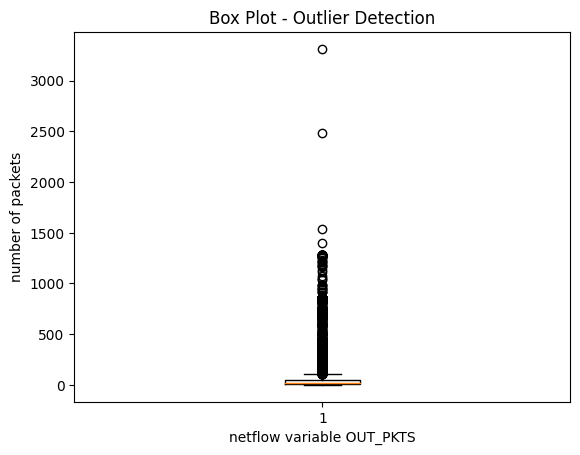

In [31]:
plt.clf() #this is to clear when i'm going back and forth debugging in the notebook
plt.xlabel('netflow variable OUT_PKTS')
plt.ylabel('number of packets')
plt.title('Box Plot - Outlier Detection')

plt.boxplot(datasample['OUT_PKTS'])

plt.show()

Seen above, there are some very distant outlier values. I'll zoom in on the mean to show where most of the values are:

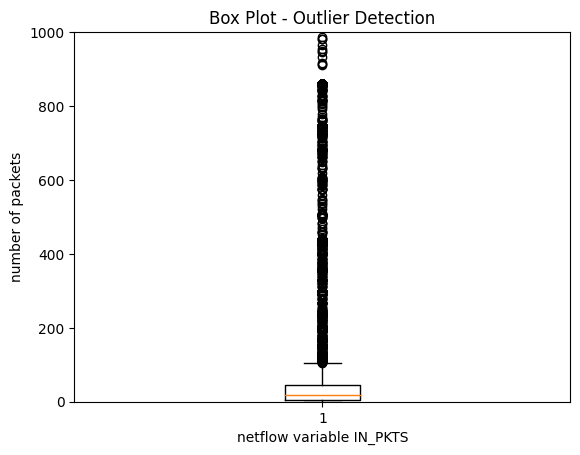

In [32]:
plt.clf()
plt.xlabel('netflow variable IN_PKTS')
plt.ylabel('number of packets')
plt.title('Box Plot - Outlier Detection')

plt.boxplot(datasample['OUT_PKTS'])
plt.ylim(0, 1000)
plt.show()
#below I'll make it easier to see the majority data spread.

<font color=green>I can see the outlier values above the top whisker of 1 std above. The red line is the mean and the box is where the middle 50% of the data resides. Here it's 0 - 18. The outliers are much higher.</font>

# <font color=green>Outlier Method 2: Z score
<font color=green>I can also look at zscores to find outliers</font>

In [33]:
zf = pd.DataFrame(no_benign_df.drop(['Attack'], axis = 1))
for c in no_benign_df.drop(['Attack'], axis = 1).columns:
    zf[c] = zscore(no_benign_df[c])

In [34]:
zf = zf.fillna(0)
zf

,index,IPV4_SRC_ADDR,L4_SRC_PORT,IPV4_DST_ADDR,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,IN_PKTS,OUT_BYTES,...,NUM_PKTS_1024_TO_1514_BYTES,TCP_WIN_MAX_IN,TCP_WIN_MAX_OUT,ICMP_TYPE,ICMP_IPV4_TYPE,DNS_QUERY_ID,DNS_QUERY_TYPE,DNS_TTL_ANSWER,FTP_COMMAND_RET_CODE,Label
0,-0.834488,0.524344,1.384886,-0.168185,-0.201628,-0.386512,0.135585,-0.043498,-0.041629,-0.039759,...,-0.059001,0.828508,0.796255,1.738398,1.738566,-0.273286,-0.072839,-0.013717,-0.283991,0.0
1,0.409749,-1.251369,0.741805,0.526049,-0.208584,-0.386512,-0.288588,6.948842,6.878090,0.005115,...,6.082158,0.828508,0.796255,0.045939,0.045164,-0.273286,-0.072839,-0.013717,-0.283991,0.0
2,-0.544805,-1.251369,-0.757813,0.178932,-0.209090,-0.386512,-0.227992,-0.044038,-0.030444,0.008813,...,-0.017043,0.828508,0.796255,-0.438714,-0.438665,-0.273286,-0.072839,-0.013717,2.686869,0.0
3,-1.017605,-0.363512,-0.555563,0.178932,-0.189106,-0.386512,0.499163,-0.026451,-0.026716,-0.060366,...,-0.051372,0.828508,0.796255,1.061074,1.061205,-0.273286,-0.072839,-0.013717,-0.283991,0.0
4,-0.521859,1.412201,1.169073,0.526049,-0.209090,-0.386512,-0.227992,-0.045389,-0.067727,-0.060225,...,-0.066630,0.828508,0.796255,-0.233098,-0.233038,-0.273286,-0.072839,-0.013717,3.132498,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74995,0.772916,-0.363512,1.621734,0.526049,-0.155462,-0.386512,-0.288588,-0.042820,-0.034173,-0.057904,...,-0.066630,0.828508,0.796255,0.093469,0.093547,-0.273286,-0.072839,-0.013717,-0.283991,0.0
74996,1.239165,-1.251369,-1.246716,-0.515303,-0.211746,-0.280691,-0.288588,-0.045210,-0.071456,-0.061663,...,-0.066630,-1.204232,-1.254443,-0.886231,-0.886207,-0.273286,-0.072839,-0.013717,-0.283991,0.0
74997,-0.233652,-0.363512,0.862897,-0.168185,-0.205043,-0.153706,-0.288588,-0.045397,-0.071456,-0.061663,...,-0.066630,-1.204232,-1.254443,-0.886231,-0.886207,3.158505,0.428917,-0.013717,-0.283991,0.0
74998,-0.010221,0.524344,0.473251,-1.209537,-0.201628,-0.386512,0.135585,-0.043458,-0.041629,-0.020863,...,-0.051372,0.828508,0.796255,1.823063,1.823236,-0.273286,-0.072839,-0.013717,-0.283991,0.0


In [35]:
zf.columns

Index(['index', 'IPV4_SRC_ADDR', 'L4_SRC_PORT', 'IPV4_DST_ADDR', 'L4_DST_PORT',
       'PROTOCOL', 'L7_PROTO', 'IN_BYTES', 'IN_PKTS', 'OUT_BYTES', 'OUT_PKTS',
       'TCP_FLAGS', 'CLIENT_TCP_FLAGS', 'SERVER_TCP_FLAGS',
       'FLOW_DURATION_MILLISECONDS', 'DURATION_IN', 'DURATION_OUT', 'MIN_TTL',
       'MAX_TTL', 'LONGEST_FLOW_PKT', 'SHORTEST_FLOW_PKT', 'MIN_IP_PKT_LEN',
       'MAX_IP_PKT_LEN', 'SRC_TO_DST_SECOND_BYTES', 'DST_TO_SRC_SECOND_BYTES',
       'RETRANSMITTED_IN_BYTES', 'RETRANSMITTED_IN_PKTS',
       'RETRANSMITTED_OUT_BYTES', 'RETRANSMITTED_OUT_PKTS',
       'SRC_TO_DST_AVG_THROUGHPUT', 'DST_TO_SRC_AVG_THROUGHPUT',
       'NUM_PKTS_UP_TO_128_BYTES', 'NUM_PKTS_128_TO_256_BYTES',
       'NUM_PKTS_256_TO_512_BYTES', 'NUM_PKTS_512_TO_1024_BYTES',
       'NUM_PKTS_1024_TO_1514_BYTES', 'TCP_WIN_MAX_IN', 'TCP_WIN_MAX_OUT',
       'ICMP_TYPE', 'ICMP_IPV4_TYPE', 'DNS_QUERY_ID', 'DNS_QUERY_TYPE',
       'DNS_TTL_ANSWER', 'FTP_COMMAND_RET_CODE', 'Label'],
      dtype='object')

<font color=green>Above , I printed calculated the Z score for all the features in the data set which shows how many standard deviations each value is from the mean. </font>

In [36]:
for z in zf.columns:
    print(zf[zf[z]>1])

          index  IPV4_SRC_ADDR  L4_SRC_PORT  IPV4_DST_ADDR  L4_DST_PORT  \
7      1.249829      -1.251369    -1.246716      -0.515303    -0.211746   
14     1.189000      -1.251369     1.267485      -1.556655    -0.201628   
19     1.443291       1.412201     0.053009      -1.556655    -0.201628   
20     1.458893      -0.363512     1.529814       0.178932    -0.155462   
26     1.126108      -0.363512     0.625427      -0.168185    -0.201628   
...         ...            ...          ...            ...          ...   
74975  1.175241       0.524344     1.489346      -0.515303    -0.209090   
74979  1.101591      -1.251369     1.283628       1.567401    -0.201628   
74987  1.341914      -1.251369     0.399697      -0.862420    -0.209090   
74989  1.106256      -0.363512     0.492284       0.178932    -0.209090   
74996  1.239165      -1.251369    -1.246716      -0.515303    -0.211746   

       PROTOCOL  L7_PROTO  IN_BYTES   IN_PKTS  OUT_BYTES  ...  \
7      4.735208 -0.288588 -0.04515

          index  IPV4_SRC_ADDR  L4_SRC_PORT  IPV4_DST_ADDR  L4_DST_PORT  \
1      0.409749      -1.251369     0.741805       0.526049    -0.208584   
177    0.405072      -1.251369    -0.013207       0.873167    -0.208584   
182    1.112807       0.524344     1.654730       0.873167    -0.201628   
218   -0.854304      -0.363512    -1.149860       0.178932     0.006181   
305   -0.637438      -0.363512    -1.157687       0.178932    -0.208584   
...         ...            ...          ...            ...          ...   
74531 -1.151037       1.412201    -0.674965       0.178932    -0.209090   
74533  0.207874      -0.363512     1.574462       0.873167    -0.189106   
74589 -0.740890      -0.363512     1.064124       1.567401    -0.189106   
74649  0.447386      -1.251369    -0.803839      -0.168185    -0.155462   
74696  0.681718      -0.363512     1.083246      -1.556655    -0.208584   

       PROTOCOL  L7_PROTO   IN_BYTES    IN_PKTS  OUT_BYTES  ...  \
1     -0.386512 -0.288588   6.94

          index  IPV4_SRC_ADDR  L4_SRC_PORT  IPV4_DST_ADDR  L4_DST_PORT  \
1      0.409749      -1.251369     0.741805       0.526049    -0.208584   
27     0.963041      -0.363512    -0.476540      -0.862420    -0.201628   
47     1.174475       1.412201     1.051139       1.220284    -0.208584   
177    0.405072      -1.251369    -0.013207       0.873167    -0.208584   
182    1.112807       0.524344     1.654730       0.873167    -0.201628   
...         ...            ...          ...            ...          ...   
74381  0.395953       0.524344    -0.456484       1.220284    -0.197833   
74424 -0.068863       0.524344     0.486014      -0.168185    -0.197833   
74554  1.230899      -1.251369    -0.473427       0.526049    -0.193659   
74696  0.681718      -0.363512     1.083246      -1.556655    -0.208584   
74722 -0.232330      -0.363512    -0.502777      -0.515303    -0.208584   

       PROTOCOL  L7_PROTO   IN_BYTES    IN_PKTS  OUT_BYTES  ...  \
1     -0.386512 -0.288588   6.94

<font color=green>To find outliers I can choose a z score I think is too high (3 in this case) and print out that data or remove it. In my case, these outliers are likely indicative of activity that I'm looking for so I want to keep them. This is in output above</font>

In [37]:
plt.clf()# clear plot


<Figure size 640x480 with 0 Axes>

In [38]:


# Create a new DataFrame 'data_outliers_gone' by removing rows with z-scores above 3
data_outliers_gone = no_benign_df[(np.abs(zf) <= 1).all(axis=1)]

print("\nDataFrame 'data_outliers_gone' (Filtered):")
print(data_outliers_gone)



DataFrame 'data_outliers_gone' (Filtered):
         index  IPV4_SRC_ADDR  L4_SRC_PORT  IPV4_DST_ADDR  L4_DST_PORT  \
18     1216969      175451762        26672    14917112617          111   
21     1405645      175451762        18076    14917112613           80   
134    1956391      175451762        13649    14917112613         3306   
192    1353322      175451761        41309    14917112615          111   
307    2108774      175451762        16887    14917112614          179   
...        ...            ...          ...            ...          ...   
74748  1958518      175451762         9529    14917112613         3306   
74751  2140349      175451762        43293    14917112616           80   
74809  1488862      175451762        24989    14917112613          179   
74918  1712739      175451761         7621    14917112612         3306   
74927  1618906      175451762         9342    14917112614          445   

       PROTOCOL  L7_PROTO  IN_BYTES  IN_PKTS  OUT_BYTES  ...  TCP_W

# <font color=green>Outlier Method 3: I can also use a scatter plot to find outliers</font>

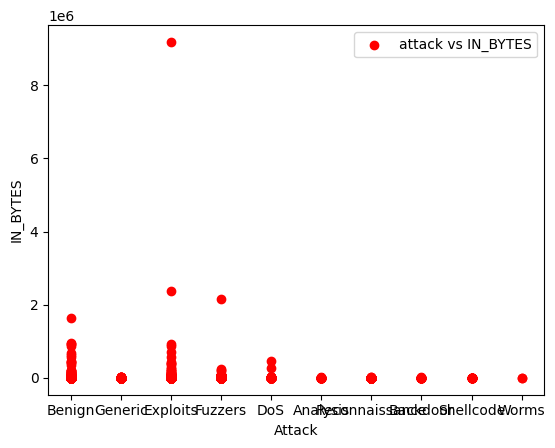

In [39]:
# Create the scatter plot
plt.scatter(datasample['Attack'], datasample['IN_BYTES'], label='attack vs IN_BYTES', color='red', marker='o')

# Set labels in axis and legend
plt.xlabel('Attack')
plt.ylabel('IN_BYTES')
plt.legend()

# Show the plot
plt.show()

<font color=green>I can do this for each column feature and compare it with attack type. I can see above there are some outliers but in general, it shows each attack type is around the same quantity of IN_BYTES. Again, I have no reason to remove these outliers in my case unless I new more details about them</font>

<font color=green>Compare this with the data with no benign net traffic</font>

In [40]:
plt.clf()


<Figure size 640x480 with 0 Axes>

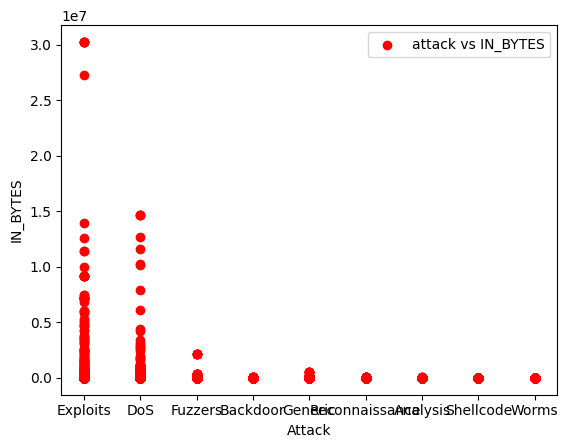

In [41]:
# Create the scatter plot
plt.scatter(no_benign_df['Attack'], no_benign_df['IN_BYTES'], label='attack vs IN_BYTES', color='red', marker='o')


# Create a scatter plot as wide as the column
 
# Set labels and legend
plt.xlabel('Attack')
plt.ylabel('IN_BYTES')
plt.legend()

# Show the plot
plt.show()

# <font color=green>Outlier detection method 4: Isolation forest</font>

<font color=green>An isolation forest is similar to a random forest in that it is composed of isolation trees which separately towards a common goal of finding isolated data referred to as anomolies. Once found, they can be removed or analyzed further</font>

In [42]:


# Calculate Anomaly Scores using Isolation Forest
# Set up the Isolation Forest model
model = IsolationForest(contamination=0.02)  # contamination determines the proportion of outliers 2% here
model.fit(datasample.drop(['Attack'], axis= 1))#drop out my target label

# Calculate anomaly scores (negative values indicate outliers)
anomaly_scores = model.fit_predict(datasample[['OUT_PKTS']])

#  Set a Threshold
threshold = -.2  # These are the ones to get rid of, this value is a common threshold

# Identify Outliers if score is less than threshold
outliers_indices = datasample.drop(['Attack'], axis= 1).index[anomaly_scores < threshold]

# Remove Outliers
datasample_cleaned = datasample.drop(['Attack'], axis= 1).drop(index=outliers_indices)

print("Original DataFrame:\n", datasample.shape)
print("\nCleaned DataFrame:\n", datasample_cleaned.shape)


Original DataFrame:
 (50000, 46)

Cleaned DataFrame:
 (49000, 45)


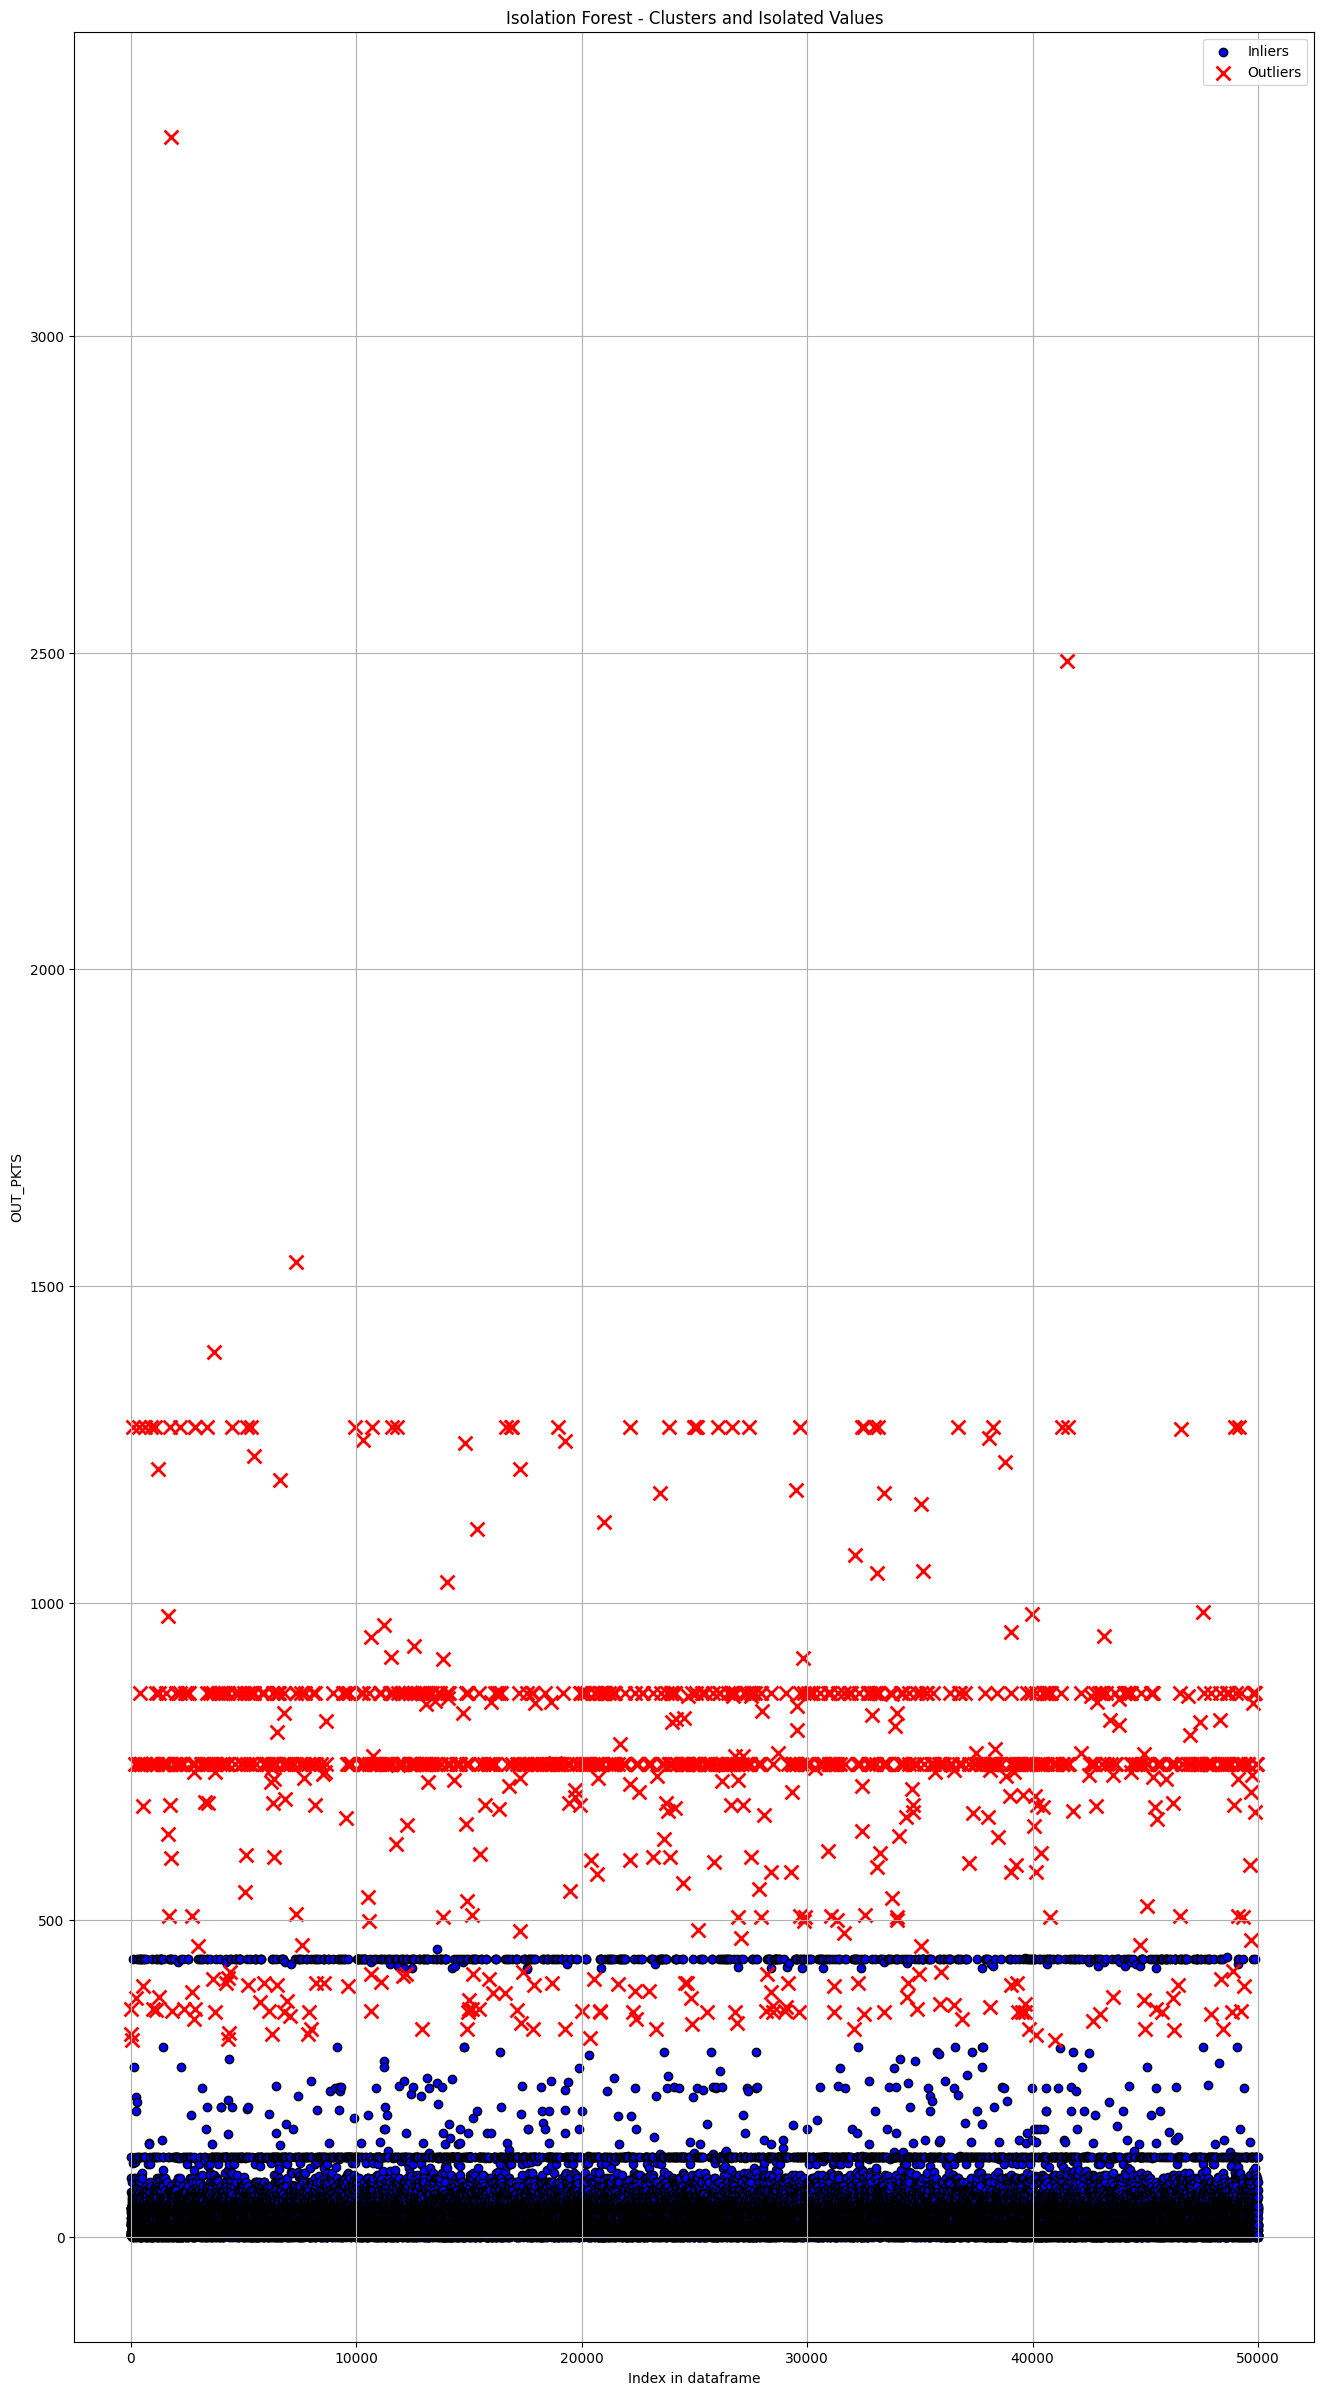

In [43]:
plt.figure(figsize=(16, 30))
plt.scatter(datasample.index[anomaly_scores == 1], datasample['OUT_PKTS'][anomaly_scores == 1],
            color='b', label='Inliers', marker='o', edgecolors='black')
plt.scatter(datasample.index[anomaly_scores == -1], datasample['OUT_PKTS'][anomaly_scores == -1],
            color='r', label='Outliers', marker='x', s=100, linewidth=2)
plt.xlabel('Index in dataframe')
plt.ylabel('OUT_PKTS')
plt.title('Isolation Forest - Clusters and Isolated Values')
plt.legend()
plt.grid(True)
plt.show()

#below I'll visualize outliers in the OUT_PKTS feature, you'll likely see a few very extreme outliers that stretch the graph a lot.



<font color=green>Possible outliers are the True values in each data position. I create a parallel dataframe with outliers removed for future comparison. I made the plot extra tall to show the spread and to include an extreme outlier.</font>

# 3.3 Data Quality and Consistency

<font color=green>1. Ensure data quality by verifying data consistency and accuracy.</font>


In [44]:
datasample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 46 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   index                        50000 non-null  int64 
 1   IPV4_SRC_ADDR                50000 non-null  int64 
 2   L4_SRC_PORT                  50000 non-null  int64 
 3   IPV4_DST_ADDR                50000 non-null  int64 
 4   L4_DST_PORT                  50000 non-null  int64 
 5   PROTOCOL                     50000 non-null  int64 
 6   L7_PROTO                     50000 non-null  int64 
 7   IN_BYTES                     50000 non-null  int64 
 8   IN_PKTS                      50000 non-null  int64 
 9   OUT_BYTES                    50000 non-null  int64 
 10  OUT_PKTS                     50000 non-null  int64 
 11  TCP_FLAGS                    50000 non-null  int64 
 12  CLIENT_TCP_FLAGS             50000 non-null  int64 
 13  SERVER_TCP_FLAGS             50

<font color=green>In the previous section I normalized the data so that the types are uniform </font>

### 2. Check for any duplicate records or potential errors and correct them as needed.


In [45]:
datasample.duplicated().sum()

0

<font color=green>I can easily remove the rows given by X.duplicated(). I didn't find any erroneous data, but I didn't look to closely at the valid ranges for each feature. These are standard network metrics and have standard acceptable values.</font>

In [46]:
datasample.drop_duplicates(inplace=True)
no_benign_df.drop_duplicates(inplace = True)

In [47]:
datasample.duplicated().sum()

0

### 3. If you did perform some transformation on the dataset, in at least 25 words, explain what
### and why?


<font color=green>Yes, I converted the ip addresses to integer types for use with the machine learning models. I could also have done this with label encoding which I'll show as an alternative reversible option in the next section.
2. I removed all the 'benign' attacks to see what this does to the model compared with leaving them in. 3. I removed duplicated rows which reduces processing time. 4. In the next section after encoding, I create a correlation heatmap to find separate independent features that correlated, I can remove these to reduce multicolinearity.
5. I'll also remove redundant variables that do not contribute to the dependant label.<BR>6. I also will encode the Attack strings in the next section. 7. In the model section 5, I analyze each features importance. I can remove the less important features to improve performance. I can't do that yet, because I have not created the model yet and still need to prepare the data.</font>

# 3.4 Data Preparation for Model training

1. Convert the dataset into a form that a model can ingest.
2. This may include shuffling the dataset and splitting it into train, test, and validation
3. Label encoding may be needed.
4. You may also have to normalize data.
5. Whatever transformation you performed to the data, explain why you did so in at least 25
words.


<font color=green>There is a feature called 'Label' that is binary and is 1 if it's an attack and 0 if benign. I'm going to change it's name to Is_Attack to be more clear</font>

In [48]:
datasample.rename(columns={'Label': 'Is_Attack'}, inplace=True)
no_benign_df.rename(columns = {'Label': 'Is_Attack'}, inplace=True)

<font color=green>I will encode the values of the attack type stored in y as an example of encoding strings to integer values for use with machine learning models</font>

In [49]:
datasample['Attack'].info()


<class 'pandas.core.series.Series'>
RangeIndex: 50000 entries, 0 to 49999
Series name: Attack
Non-Null Count  Dtype 
--------------  ----- 
50000 non-null  object
dtypes: object(1)
memory usage: 390.8+ KB


In [50]:
label_encoder = preprocessing.LabelEncoder() #create label encoder object 

In [51]:
datasample['Attack'] = label_encoder.fit_transform(datasample['Attack'])#encode the strings in attack label (10)


# Create a mapping between original attack values and encoded labels
label_mapping1 = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

# Create a label DataFrame to show the relationships between original and encoded values
label_mapping_df1 = pd.DataFrame(list(label_mapping1.items()), columns=['Original Attack', 'Encoded Attack'])

#no benign data
no_benign_df['Attack'] = label_encoder.fit_transform(no_benign_df['Attack'])

# Create a mapping between original attack values and encoded labels
label_mapping2 = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

# Create a label DataFrame to show the relationships between original attack type and encoded values
label_mapping_df2 = pd.DataFrame(list(label_mapping2.items()), columns=['Original Attack', 'Encoded Attack'])


In [52]:
label_mapping_df1

,Original Attack,Encoded Attack
0,Analysis,0
1,Backdoor,1
2,Benign,2
3,DoS,3
4,Exploits,4
5,Fuzzers,5
6,Generic,6
7,Reconnaissance,7
8,Shellcode,8
9,Worms,9


In [53]:
datasample['Attack'].unique()


array([2, 6, 4, 5, 3, 0, 7, 1, 8, 9])

<font color=green>Here I split the data into train test split an 70/15/15</font>

In [54]:
# Split the data into training and testing sets
X_train, X_test_and_val, y_train, y_test_and_val = train_test_split(datasample.drop(['Attack'], axis= 1), datasample['Attack'], train_size = 0.7,random_state = 100)
X_val, X_test, y_val, y_test = train_test_split(X_test_and_val, y_test_and_val, test_size = 0.5, random_state = 100)

In [55]:
print(X_train.shape, X_test_and_val.shape, y_train.shape, y_test_and_val.shape)
print(X_val.shape, X_test.shape, y_val.shape, y_test.shape)

(35000, 45) (15000, 45) (35000,) (15000,)
(7500, 45) (7500, 45) (7500,) (7500,)


# 4 Data Visualisation


Choose any two charts/plots etc to visualize the dataset and its properties. For each viz,<BR>
• Ensure your plot is clear and has all necessary labels marked.<BR>
• Write a short desc of why you choose the viz and what you understood about the dataset
from it.

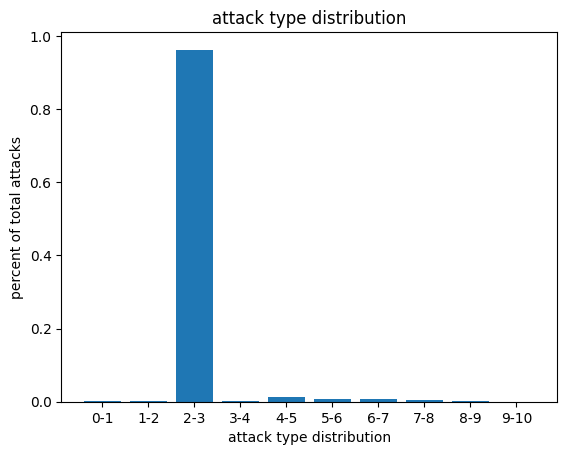

In [56]:
plt.clf()


# 10 types of attacks. I'll display the relative percentage of each type
categories = ['0-1', '1-2', '2-3', '3-4','4-5' ,'5-6' ,'6-7' ,'7-8' ,'8-9' ,'9-10' ]
count_in_range1 = len(datasample[(datasample['Attack'] >= 0) & (datasample['Attack'] < 1)])/len(datasample)
count_in_range2 = len(datasample[(datasample['Attack'] >= 1) & (datasample['Attack'] < 2)])/len(datasample)
count_in_range3 = len(datasample[(datasample['Attack'] >= 2) & (datasample['Attack'] < 3)])/len(datasample)
count_in_range4 = len(datasample[(datasample['Attack'] >= 3) & (datasample['Attack'] < 4)])/len(datasample)
count_in_range5 = len(datasample[(datasample['Attack'] >= 4) & (datasample['Attack'] < 5)])/len(datasample)
count_in_range6 = len(datasample[(datasample['Attack'] >= 5) & (datasample['Attack'] < 6)])/len(datasample)
count_in_range7 = len(datasample[(datasample['Attack'] >= 6) & (datasample['Attack'] < 7)])/len(datasample)
count_in_range8 = len(datasample[(datasample['Attack'] >= 7) & (datasample['Attack'] < 8)])/len(datasample)
count_in_range9 = len(datasample[(datasample['Attack'] >= 8) & (datasample['Attack'] < 9)])/len(datasample)
count_in_range10 = len(datasample[(datasample['Attack'] >= 9) & (datasample['Attack'] < 10)])/len(datasample)

values = [count_in_range1,count_in_range2,count_in_range3,count_in_range4,count_in_range5,count_in_range6,count_in_range7,count_in_range8,count_in_range9,count_in_range10]

# Create the bar chart
plt.bar(categories, values)


plt.xlabel('attack type distribution')
plt.ylabel('percent of total attacks')
plt.title('attack type distribution')

# Display the chart
plt.show()

<font color=green>The benign data greatly outnumbers the others, so let me remove this and only look at the attacks</font>


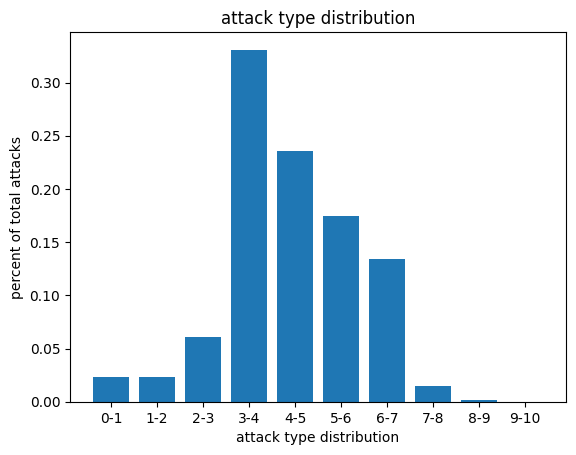

In [57]:
plt.clf()


# Sample data
categories = ['0-1', '1-2', '2-3', '3-4','4-5' ,'5-6' ,'6-7' ,'7-8' ,'8-9' ,'9-10' ]
count_in_range1 = len(no_benign_df[(no_benign_df['Attack'] >= 0) & (no_benign_df['Attack'] < 1)])/len(no_benign_df)
count_in_range2 = len(no_benign_df[(no_benign_df['Attack'] >= 1) & (no_benign_df['Attack'] < 2)])/len(no_benign_df)
count_in_range3 = len(no_benign_df[(no_benign_df['Attack'] >= 2) & (no_benign_df['Attack'] < 3)])/len(no_benign_df)
count_in_range4 = len(no_benign_df[(no_benign_df['Attack'] >= 3) & (no_benign_df['Attack'] < 4)])/len(no_benign_df)
count_in_range5 = len(no_benign_df[(no_benign_df['Attack'] >= 4) & (no_benign_df['Attack'] < 5)])/len(no_benign_df)
count_in_range6 = len(no_benign_df[(no_benign_df['Attack'] >= 5) & (no_benign_df['Attack'] < 6)])/len(no_benign_df)
count_in_range7 = len(no_benign_df[(no_benign_df['Attack'] >= 6) & (no_benign_df['Attack'] < 7)])/len(no_benign_df)
count_in_range8 = len(no_benign_df[(no_benign_df['Attack'] >= 7) & (no_benign_df['Attack'] < 8)])/len(no_benign_df)
count_in_range9 = len(no_benign_df[(no_benign_df['Attack'] >= 8) & (no_benign_df['Attack'] < 9)])/len(no_benign_df)
count_in_range10 = len(no_benign_df[(no_benign_df['Attack'] >= 9) & (no_benign_df['Attack'] < 10)])/len(no_benign_df)

values = [count_in_range1,count_in_range2,count_in_range3,count_in_range4,count_in_range5,count_in_range6,count_in_range7,count_in_range8,count_in_range9,count_in_range10]

# Create the bar chart
plt.bar(categories, values)

# Add labels and title

plt.xlabel('attack type distribution')
plt.ylabel('percent of total attacks')
plt.title('attack type distribution')

# Display the chart
plt.show()

<font color=green>Here I can see that exploits make up the largest amount of attacks.</font>

## 2 methods for feature reduction compared: PCA vs Chi squared

In [58]:
# Separate features and the dependent variable
X = no_benign_df.drop('Attack', axis=1)
y = no_benign_df['Attack']

# Standardize the features (important for PCA)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [59]:
# Perform PCA for data reduction. this is for the scree graph
pca = PCA() 
pca.fit(X_scaled)

PCA()

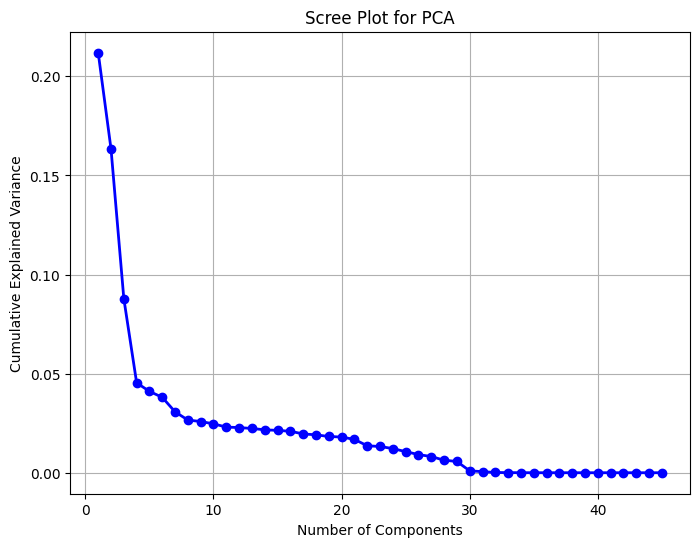

In [60]:


# Get the explained variance for each component - eigenvalues
explained_variance = pca.explained_variance_

# Calculate the cumulative explained variance, not sure i'll need this
cumulative_variance = explained_variance.cumsum()

Pcompo = np.arange(pca.n_components_) + 1

# Create the scree plot to find elbow - ideal number of features
plt.figure(figsize=(8, 6))
plt.plot(Pcompo, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
#plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot for PCA')
plt.grid(True)
plt.show()


To estimate the optimal value of n_components for the PCA, I choose the value at the 'elbow' of the scree plot above. It looks to be around 10.

In [61]:
# Separate features and the dependent variable
X = no_benign_df.drop('Attack', axis=1)
y = no_benign_df['Attack']

# Standardize the features (important for PCA)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

scaler_minmax = MinMaxScaler()
data_minmax = scaler_minmax.fit_transform(X)

# Perform PCA for data reduction
pca = PCA(n_components=10)  #number of principal components
X_pca = pca.fit_transform(data_minmax)

# Create a new DataFrame with the principal components and the 'attack' label
pca_df = pd.DataFrame(data=X_pca)
pca_df['Attack'] = y



`<font color=green>Below is PCA heatmap. The rows are the principle components and the columns are the original features. The features might not easily be visible on all screen sizes</font>

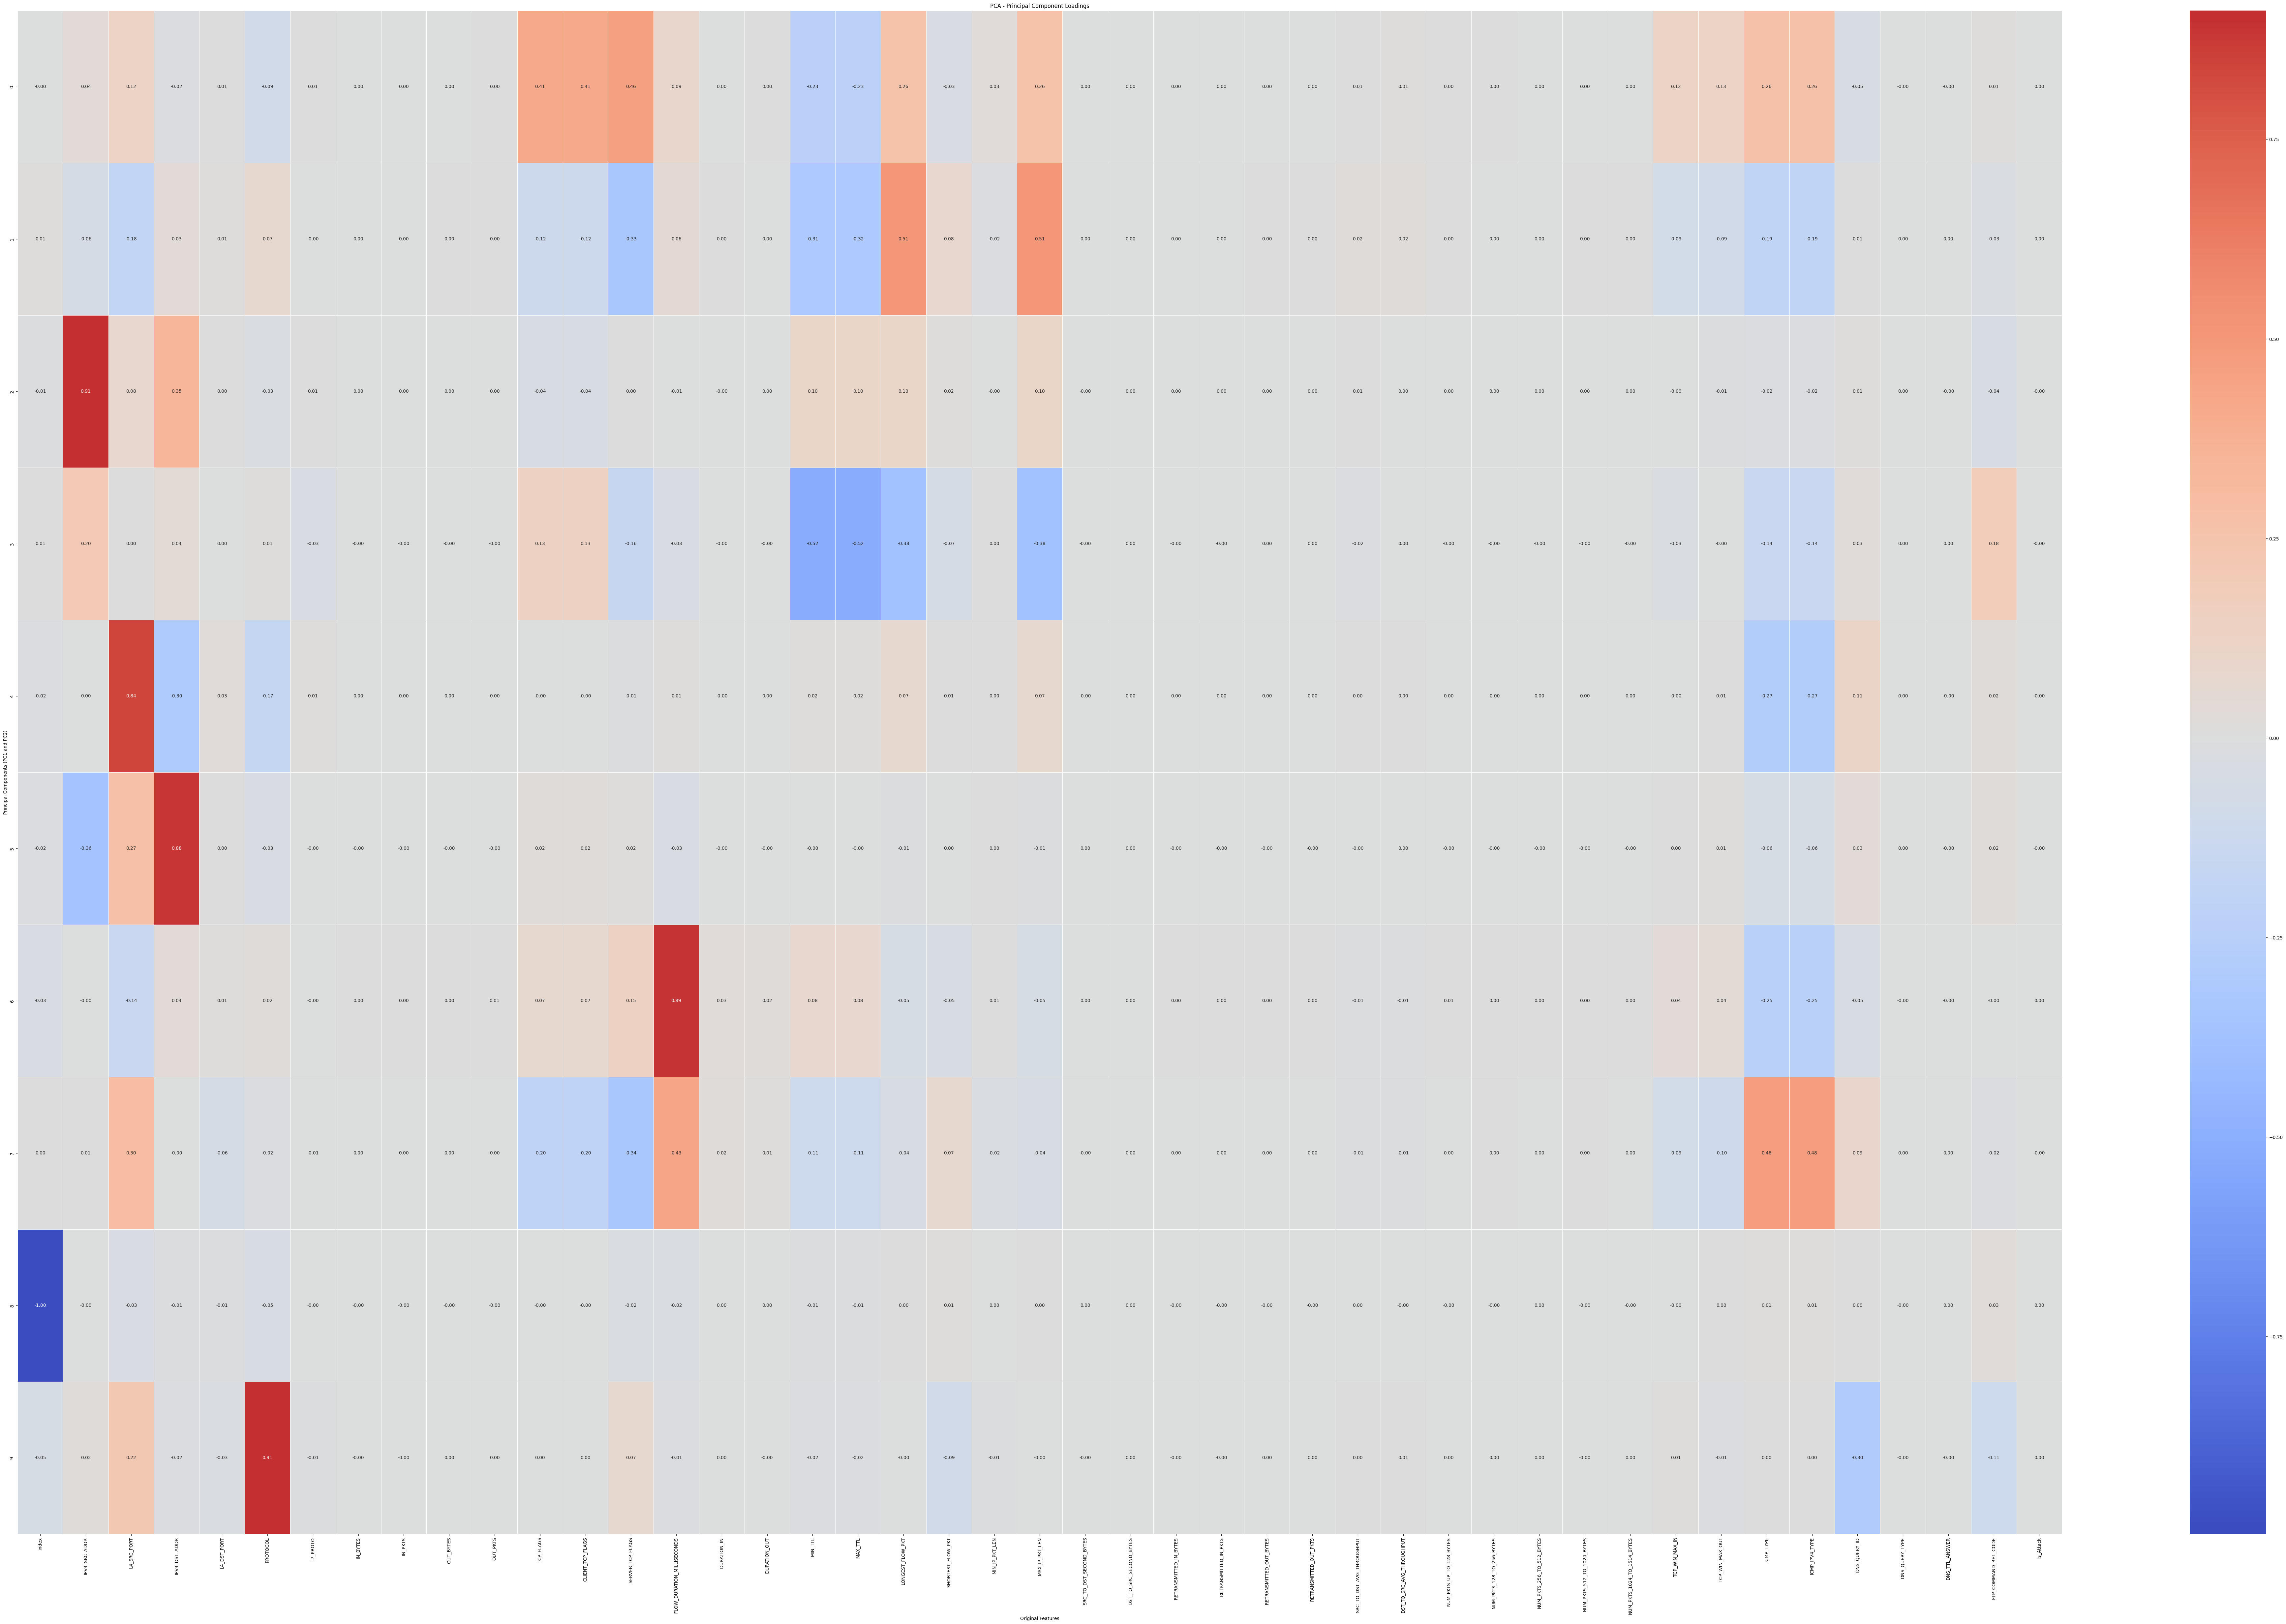

In [62]:



# Get the principal component loadings (eigenvectors) for the original features
components_df = pd.DataFrame(data=pca.components_, columns=X.columns)

# Create a heatmap to visualize the principal component loadings
plt.figure(figsize=(100, 60))
sns.heatmap(components_df, cmap='coolwarm', annot=True, fmt=".2f", center=0, linewidths=0.5)
plt.title('PCA - Principal Component Loadings')
plt.xlabel('Original Features')
plt.ylabel('Principal Components (PC1 and PC2)')
plt.show()


<font color=green>The dark red the color, the more correlated the row is with that column. The low blue values are the ones which should be considered for dropping.</font>

## <font color=green>Split the data into training and testing sets for PCA testing the models later</font>

In [63]:
# Split the data into training and testing sets for PCA testing the models later
X_train_PCA, X_test_and_val_PCA, y_train_PCA, y_test_and_val_PCA = train_test_split(pca_df.drop(['Attack'], axis=1), pca_df['Attack'], train_size = 0.7,random_state = 100)
X_val_PCA, X_test_PCA, y_val_PCA, y_test_PCA = train_test_split(X_test_and_val_PCA, y_test_and_val_PCA, test_size = 0.5, random_state = 100)

## Below I use chi squared / p_value analysis to reduce the NO_BENIGN data set by finding the most important features


In [64]:
#initilize empty results variables
selected_features = []
p_values = []
chi2_values = []

# Compute chi-square statistic and p-values for each categorical feature in the network set
for cat_feature in no_benign_df.drop(columns=['Attack']).columns.to_list()[1:]:
    contingency_table = pd.crosstab(no_benign_df['Attack'], no_benign_df[cat_feature])
    chi2, p_value, _, _ = chi2_contingency(contingency_table)
    p_values.append(p_value)
    chi2_values.append(chi2)
    if p_value < 0.05:  #Common value for significance level . values under this will be selected
        selected_features.append(cat_feature)#add to significant feature list

# Create a new dataset with only the selected features
chi_reduced_data = no_benign_df[selected_features + ['Attack']]
for i in range(len(no_benign_df.drop(columns=['Attack']).columns.to_list()[1:])):
    print(f"Feature: {no_benign_df.drop(columns=['Attack']).columns.to_list()[1:][i]}")
    print(f"Chi-square value: {chi2_values[i]}")
    print(f"P-value: {p_values[i]}")
    print("-------------------")

Feature: IPV4_SRC_ADDR
Chi-square value: 2238.519990634264
P-value: 0.0
-------------------
Feature: L4_SRC_PORT
Chi-square value: 327298.7321305078
P-value: 0.0
-------------------
Feature: IPV4_DST_ADDR
Chi-square value: 9697.861413843468
P-value: 0.0
-------------------
Feature: L4_DST_PORT
Chi-square value: 258392.14491469448
P-value: 0.0
-------------------
Feature: PROTOCOL
Chi-square value: 43642.59926746976
P-value: 0.0
-------------------
Feature: L7_PROTO
Chi-square value: 33806.77063911937
P-value: 0.0
-------------------
Feature: IN_BYTES
Chi-square value: 235376.9701899293
P-value: 0.0
-------------------
Feature: IN_PKTS
Chi-square value: 43289.525762171485
P-value: 0.0
-------------------
Feature: OUT_BYTES
Chi-square value: 113749.00908376607
P-value: 0.0
-------------------
Feature: OUT_PKTS
Chi-square value: 50096.204605873434
P-value: 0.0
-------------------
Feature: TCP_FLAGS
Chi-square value: 49352.7268356039
P-value: 0.0
-------------------
Feature: CLIENT_TCP_FLA

In [65]:
chi_reduced_data.shape

(75000, 44)

The model with 45 original features now has been reduced

# 5 Model Training

## 5.1 Picking a model


1. Pick any machine learning algorithm that you think works for your problem and data. It
needn’t necessarily be an algorithm taught in class.

<font color=green>The first machine learning model I will be using is call a random forest classifier and is a collection of decision tree algorithms which work separately to classify the input data. Each tree works on a random subset (assuming bootstrap parameter is true) of the total data and creates a model and associated probability. When all the trees are finished, they are combined together with weighting that is dependent on how good the probability is for each tree (referred to as voting). The resulting forest is a collection of tree models with the better models weighted higher. The analogy is that many different decision trees are grown to create a forest of decision trees that work together to classify data. Random forest classifiers also can be used for regression applications that predict numerical values. It works well with both linear and non-linear data. I compared normalized data with non-normalized data for my second model (MLP classifier) instead of the random forest classifier because the random forest classifier already had a high accuracy while the MLP did not.</font>

## 5.2 Model Training

1. Train your model and report your model performance on your validation dataset.

<font color=green>I will use both normalized and non normalized data and also data with and without benign data. Also, I will remove the 'isAttack' feature and test against leaving it in since it's a highly correlated feature with attack.</font>

# <font color=blue>A1. Random Forest Classifier on datasample with benign included</font>

<font color=green> I needed to use the ravel method to reshape, otherwise I got warnings</font>

In [66]:

# Create and train the Random Forest Classifier model
rf_classifier_all = RandomForestClassifier(random_state=42)
rf_classifier_all.fit(X_train, y_train.values.ravel())


# Make predictions on the validation set
y_pred = rf_classifier_all.predict(X_val)

# Evaluate the model's accuracy
accuracy = accuracy_score(y_val.values.ravel(), y_pred.ravel())
print("Accuracy:", accuracy)

Accuracy: 0.992


<font color=green>This is a great accuracy score for the main model on validation data</font>

In [67]:
mse = mean_squared_error(y_val, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.07093333333333333


<font color=green>This is a very good MSE considering it doesn't deviate much from the categorical attack integer values much.</font>

test data:

In [68]:
# Make predictions on the validation set
y_pred = rf_classifier_all.predict(X_test)

# Evaluate the model's accuracy
accuracy = accuracy_score(y_test.values.ravel(), y_pred.ravel())
print("Accuracy:", accuracy)

Accuracy: 0.9921333333333333


Good test results too

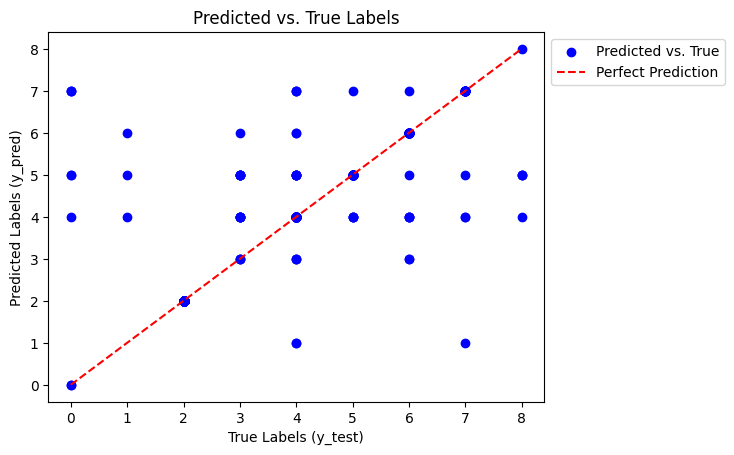

In [69]:

plt.scatter(y_test, y_pred, color='blue', label='Predicted vs. True')
plt.plot([min(y_pred), max(y_pred)], [min(y_pred), max(y_pred)], color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel('True Labels (y_test)')
plt.ylabel('Predicted Labels (y_pred)')
plt.legend()
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title('Predicted vs. True Labels')
plt.show()

### Get feature importances and sort them. I can find the features that do not contribute much and potentially remove them in the future.

In [70]:
feature_importance = pd.Series(rf_classifier_all.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print(feature_importance)

Is_Attack                      0.179733
IPV4_DST_ADDR                  0.102118
MAX_TTL                        0.076417
MIN_TTL                        0.072772
L4_DST_PORT                    0.040197
index                          0.037629
SHORTEST_FLOW_PKT              0.037482
IPV4_SRC_ADDR                  0.033106
MAX_IP_PKT_LEN                 0.028384
PROTOCOL                       0.028156
SRC_TO_DST_SECOND_BYTES        0.027696
LONGEST_FLOW_PKT               0.027067
OUT_BYTES                      0.024025
MIN_IP_PKT_LEN                 0.020702
IN_BYTES                       0.017398
NUM_PKTS_UP_TO_128_BYTES       0.016773
SRC_TO_DST_AVG_THROUGHPUT      0.016623
OUT_PKTS                       0.016032
DST_TO_SRC_SECOND_BYTES        0.015827
DST_TO_SRC_AVG_THROUGHPUT      0.015741
DNS_QUERY_TYPE                 0.014979
CLIENT_TCP_FLAGS               0.013012
TCP_FLAGS                      0.012560
ICMP_IPV4_TYPE                 0.012362
DNS_QUERY_ID                   0.011967


<font color=green>The higher the value of importance the more it contributes to the result. It makes sense intuitively that the highest correlated value is L4_DST_PORT , because ports are associated with vulnerabilities and this is what attackers scan for. The feature named 'Is Attack' is a binary value that describes if it's an attack or not. IPV4_DST_ADDR might be useful because it was designated as a target vulnerable machine.</font>

# <font color=blue>A2 Confusion matrix for random forest classifier on datasample</font>

In [71]:

true_labels = y_test
predicted_labels = y_pred

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Calculate overall accuracy
accuracy = accuracy_score(true_labels, predicted_labels)

# Calculate precision, recall, and F1-score for class 1 (positive class)
precision_class_1 = precision_score(true_labels, predicted_labels, pos_label=1, average='micro')
recall_class_1 = recall_score(true_labels, predicted_labels, pos_label=1, average= 'micro')
f1_score_class_1 = f1_score(true_labels, predicted_labels, pos_label=1, average = 'micro')

print("Confusion Matrix:")
print(cm)
print("Overall Accuracy:", accuracy)
print("Precision (Class 1):", precision_class_1)
print("Recall (Class 1):", recall_class_1)
print("F1-score (Class 1):", f1_score_class_1)

Confusion Matrix:
[[   2    0    0    0    1    2    0    3    0]
 [   0    0    0    0    1    1    1    0    0]
 [   0    0 7220    0    0    0    0    0    0]
 [   0    0    0    3    6    6    1    0    0]
 [   0    2    0    3   73    6    2    3    0]
 [   0    0    0    0    4   58    0    1    0]
 [   0    0    0    2    4    1   52    1    0]
 [   0    1    0    0    2    1    0   32    0]
 [   0    0    0    0    1    3    0    0    1]]
Overall Accuracy: 0.9921333333333333
Precision (Class 1): 0.9921333333333333
Recall (Class 1): 0.9921333333333333
F1-score (Class 1): 0.9921333333333333


In [72]:
print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       1.00      0.25      0.40         8
           1       0.00      0.00      0.00         3
           2       1.00      1.00      1.00      7220
           3       0.38      0.19      0.25        16
           4       0.79      0.82      0.81        89
           5       0.74      0.92      0.82        63
           6       0.93      0.87      0.90        60
           7       0.80      0.89      0.84        36
           8       1.00      0.20      0.33         5

    accuracy                           0.99      7500
   macro avg       0.74      0.57      0.59      7500
weighted avg       0.99      0.99      0.99      7500



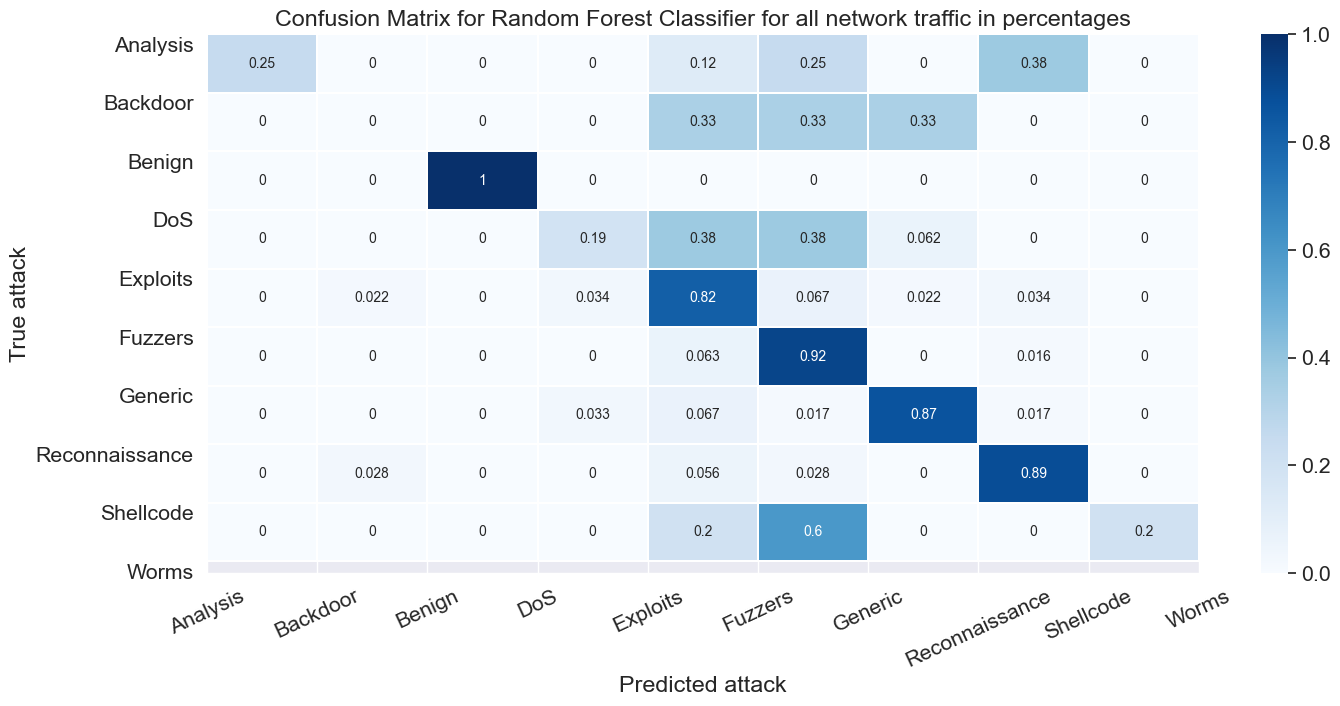

In [73]:
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]# I have to do this in a ratio because there's so many benign values that the heatmap is useless otherwise



# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Blues, linewidths=0.2)

# make plot look good
label_mapping1 #attack type encoding mapping
tick_marks = np.arange(len(label_mapping1))
tick_marks2 = tick_marks + 0.2
plt.xticks(tick_marks, label_mapping1, rotation=25)
plt.yticks(tick_marks2, label_mapping1, rotation=0)
plt.xlabel('Predicted attack')
plt.ylabel('True attack')
plt.title('Confusion Matrix for Random Forest Classifier for all network traffic in percentages')
plt.show()

<font color=green>A confusion matrix has rows which represent true values and columns which represent predicted values. The values add up to 100% along each row or column. It's ideal to have the heatmap value most dense on a diagonal line where they match. I can see above in the matrix that most of the values are along the center line which is good. Benign matches were the highest.</font><BR><BR>
<font color=green>  Precision represents the percentage of true positives out of all the positives. Slightly similar is recall which represents the percentage of true positives out of actual positives. This value is very high here which means it found most of the Attacks correctly. F-1 score is a special type of mean of the previous 2 values, but I think it's only valid in binary classifications, which mine is not. I read that if I set the average setting to micro, the f1 might apply in this situation, but I'm honesty not sure. The weighted averages taken the amounts of each class and assign larger weights to larger classes (like benign and exploit). This might not give an overall accurate representation of the smaller classes accuracy or precision. The macro average is a better representation of this.</font>

## <font color=blue>B1. Now I'll create a model based on data *without* the highly important correlated 'Is_Attack' and 'IPV4_DST_ADDR', MIN_TTL and MAX_TTL features.</font>


In [74]:
Is_Attack_Removed_df = datasample.drop(['Is_Attack', 'IPV4_DST_ADDR','L4_DST_PORT', 'MIN_TTL','MAX_TTL'], axis = 1)


In [75]:
X_train, X_test_and_val, y_train, y_test_and_val = train_test_split(Is_Attack_Removed_df.drop(['Attack'], axis= 1), Is_Attack_Removed_df['Attack'], train_size = 0.7,random_state = 100)
X_val, X_test, y_val, y_test = train_test_split(X_test_and_val, y_test_and_val, test_size = 0.5, random_state = 100)

# Create and train the Random Forest Classifier model
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train.values.ravel())


# Make predictions on the validation set
y_pred = rf_classifier.predict(X_val)

# Evaluate the model's accuracy
accuracy = accuracy_score(y_val.values.ravel(), y_pred.ravel())
print("Accuracy:", accuracy)

Accuracy: 0.9878666666666667


While the accuracy is slightly lower without the 4 most important variables, it's still good. It is likely due to there being a large number of slightly significant variables. The new imporant features are: 

In [76]:
feature_importance = pd.Series(rf_classifier.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print(feature_importance)

MIN_IP_PKT_LEN                 0.146622
SHORTEST_FLOW_PKT              0.107094
IPV4_SRC_ADDR                  0.080631
index                          0.044268
DST_TO_SRC_AVG_THROUGHPUT      0.041249
SRC_TO_DST_SECOND_BYTES        0.039432
DST_TO_SRC_SECOND_BYTES        0.038710
MAX_IP_PKT_LEN                 0.036801
LONGEST_FLOW_PKT               0.034766
OUT_BYTES                      0.033923
PROTOCOL                       0.032759
IN_BYTES                       0.031346
NUM_PKTS_UP_TO_128_BYTES       0.030653
SRC_TO_DST_AVG_THROUGHPUT      0.027414
OUT_PKTS                       0.025385
ICMP_TYPE                      0.020224
TCP_FLAGS                      0.018227
RETRANSMITTED_IN_BYTES         0.017130
TCP_WIN_MAX_IN                 0.016823
CLIENT_TCP_FLAGS               0.016187
ICMP_IPV4_TYPE                 0.015979
L4_SRC_PORT                    0.015872
L7_PROTO                       0.014708
IN_PKTS                        0.013557
RETRANSMITTED_OUT_BYTES        0.012054


Now , I'll run the test data

In [77]:
# Make predictions on the validation set
y_pred = rf_classifier.predict(X_test)

# Evaluate the model's accuracy
accuracy = accuracy_score(y_test.values.ravel(), y_pred.ravel())
print("Accuracy:", accuracy)

Accuracy: 0.9881333333333333


### <font color=green>Now I'll compare with the data without the benign network activity</font>


# <font color=blue>C1. Random Forest classifier on data without benign values (ONLY ATTACK DATA)</font>


In [78]:
no_benign_df.describe()

,index,IPV4_SRC_ADDR,L4_SRC_PORT,IPV4_DST_ADDR,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,IN_PKTS,OUT_BYTES,...,TCP_WIN_MAX_IN,TCP_WIN_MAX_OUT,ICMP_TYPE,ICMP_IPV4_TYPE,DNS_QUERY_ID,DNS_QUERY_TYPE,DNS_TTL_ANSWER,FTP_COMMAND_RET_CODE,Is_Attack,Attack
count,7.500000e+04,7.500000e+04,75000.000000,7.500000e+04,75000.000000,75000.000000,75000.000000,7.500000e+04,75000.000000,7.500000e+04,...,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,7.500000e+04,75000.000000,75000.0,75000.000000
mean,1.679005e+06,1.754518e+08,28034.979960,1.491711e+10,1674.132867,24.262587,4.762480,1.617757e+04,21.165787,1.217234e+04,...,9705.586800,10021.730000,18757.664147,73.266120,2548.278240,37.018080,5.337810e+05,19.118467,1.0,3.877747
std,4.818752e+05,1.126316e+00,22487.210555,2.880890e+00,7906.372605,47.250068,16.502786,3.538490e+05,268.220748,1.974014e+05,...,8059.617923,7989.041376,21165.798516,82.674365,9324.639337,508.217947,3.891430e+07,67.321014,0.0,1.421005
min,3.999000e+03,1.754518e+08,0.000000,1.491711e+10,0.000000,0.000000,0.000000,1.000000e+00,1.000000,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,1.0,0.000000
25%,1.359278e+06,1.754518e+08,3798.000000,1.491711e+10,25.000000,6.000000,0.000000,2.000000e+02,2.000000,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,1.0,3.000000
50%,1.703486e+06,1.754518e+08,27080.000000,1.491711e+10,80.000000,6.000000,0.000000,5.660000e+02,10.000000,2.560000e+02,...,16383.000000,16383.000000,12800.000000,50.000000,0.000000,0.000000,0.000000e+00,0.000000,1.0,4.000000
75%,2.064666e+06,1.754518e+08,47439.000000,1.491711e+10,179.000000,17.000000,7.000000,1.112000e+03,12.000000,7.820000e+02,...,16383.000000,16383.000000,31232.000000,122.000000,0.000000,0.000000,0.000000e+00,0.000000,1.0,5.000000
max,2.387788e+06,1.754518e+08,65535.000000,1.491711e+10,65535.000000,255.000000,231.000000,3.024141e+07,22894.000000,1.465675e+07,...,65118.000000,59719.000000,65286.000000,255.000000,65413.000000,55937.000000,4.219426e+09,501.000000,1.0,8.000000


In [79]:
# Split the data into training and testing sets
X_train, X_test_and_val, y_train, y_test_and_val = train_test_split(no_benign_df.drop(['Attack'], axis=1), no_benign_df['Attack'], train_size = 0.7,random_state = 100)
X_val, X_test, y_val, y_test = train_test_split(X_test_and_val, y_test_and_val, test_size = 0.5, random_state = 100)

In [80]:
print(X_train.shape, X_test_and_val.shape, y_train.shape, y_test_and_val.shape)
print(X_val.shape, X_test.shape, y_val.shape, y_test.shape)
#print out to be sure sizes match

(52500, 45) (22500, 45) (52500,) (22500,)
(11250, 45) (11250, 45) (11250,) (11250,)


In [81]:

# Create and train the Random Forest Classifier model
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train.values.ravel())


# Make predictions on the test set
y_pred = rf_classifier.predict(X_val)

# Evaluate the model's accuracy
accuracy = accuracy_score(y_val.values.ravel(), y_pred.ravel())
print("Accuracy:", accuracy)

Accuracy: 0.7981333333333334


In [82]:
mse = mean_squared_error(y_val, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 1.523111111111111


<font color=green>The accuracy of true positive is not as good compared with the model trained on benign data (Only attack data)</font>

Test data:

In [83]:
# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the model's accuracy
accuracy = accuracy_score(y_test.values.ravel(), y_pred.ravel())
print("Accuracy:", accuracy)

Accuracy: 0.7952888888888889


<font color=green>I will compare this with the equivalent data set but with outliers removed in the following section D for a potential improvement.</font>

# <font color=blue>C2b. Confusion matrix for Random Forest Classifier on data without benign values (ONLY ATTACK DATA)</font>

In [84]:

true_labels = y_test
predicted_labels = y_pred

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Calculate overall accuracy
accuracy = accuracy_score(true_labels, predicted_labels)

# Calculate precision, recall, and F1-score for class 1 (positive class)
precision_class_1 = precision_score(true_labels, predicted_labels, pos_label=1, average='micro')
recall_class_1 = recall_score(true_labels, predicted_labels, pos_label=1, average= 'micro')
f1_score_class_1 = f1_score(true_labels, predicted_labels, pos_label=1, average = 'micro')

print("Confusion Matrix:")
print(cm)
print("Overall Accuracy:", accuracy)
print("Precision (Class 1):", precision_class_1)
print("Recall (Class 1):", recall_class_1)
print("F1-score (Class 1):", f1_score_class_1)

Confusion Matrix:
[[  17   28   24   31   42    4   93    0    0]
 [ 120   39   50   22    7    7   30    1    1]
 [  41  126  225  255   21   20   13    0    0]
 [  26   34  190 3202   25   83  100   17    4]
 [  61   24   16   18 2411   11  137    1    0]
 [  10   26   55  167    4 1687    7    3    1]
 [  45   16   22  110  120   11 1180    0    0]
 [   0    0    1    9    1    3    0  170    0]
 [   0    0    0    9    0    0    0    0   16]]
Overall Accuracy: 0.7952888888888889
Precision (Class 1): 0.7952888888888889
Recall (Class 1): 0.7952888888888889
F1-score (Class 1): 0.7952888888888889


In [85]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.05      0.07      0.06       239
           1       0.13      0.14      0.14       277
           2       0.39      0.32      0.35       701
           3       0.84      0.87      0.85      3681
           4       0.92      0.90      0.91      2679
           5       0.92      0.86      0.89      1960
           6       0.76      0.78      0.77      1504
           7       0.89      0.92      0.90       184
           8       0.73      0.64      0.68        25

    accuracy                           0.80     11250
   macro avg       0.62      0.61      0.62     11250
weighted avg       0.80      0.80      0.80     11250



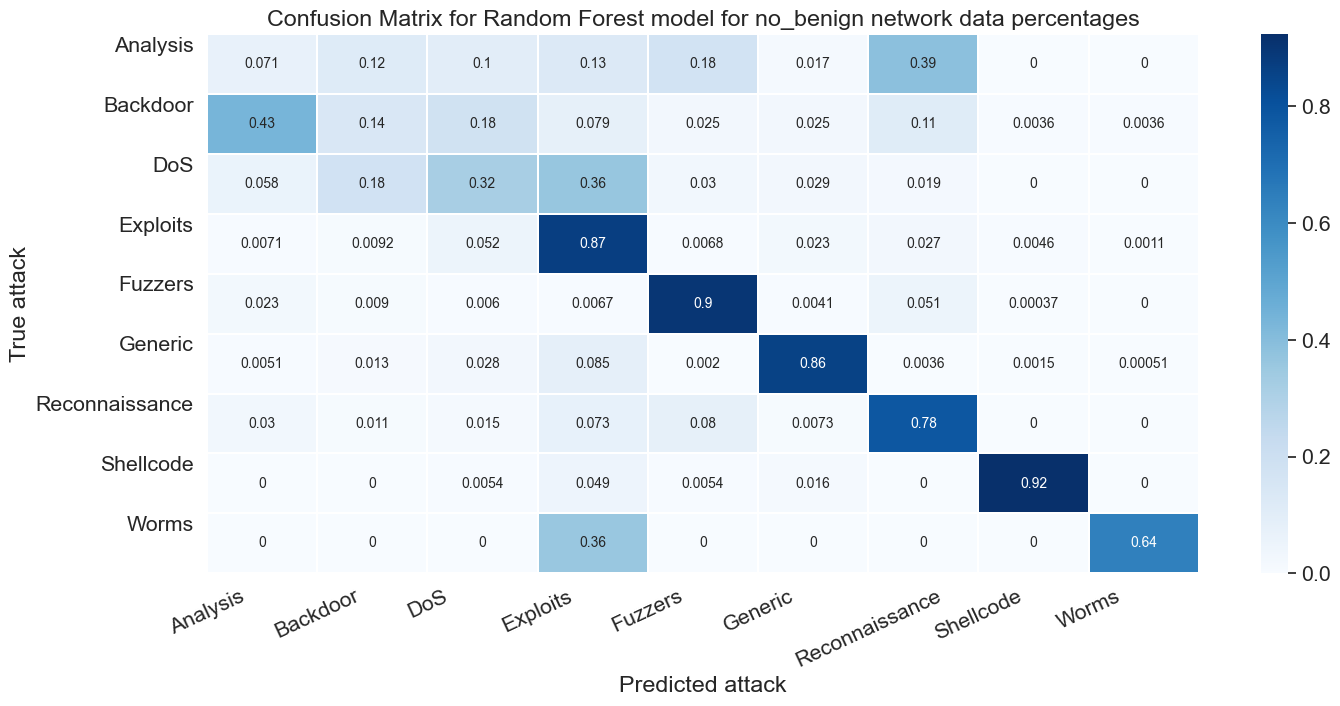

In [86]:
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Blues, linewidths=0.2)

# make plot look good
label_mapping2 #attack type encoding mapping
tick_marks = np.arange(len(label_mapping2))
tick_marks2 = tick_marks + 0.2
plt.xticks(tick_marks, label_mapping2, rotation=25)
plt.yticks(tick_marks2, label_mapping2, rotation=0)
plt.xlabel('Predicted attack')
plt.ylabel('True attack')
plt.title('Confusion Matrix for Random Forest model for no_benign network data percentages')
plt.show()

<font color=green>This is the accuracy for the benign data removed. I noticed that it's much lower than the model that included the benign data above. I can see above in the matrix that there a lot of values in the upper two quadrants which correspond to false positives as predicted. The recall value is very low here and says that it identified many benign data as an attack when it was not.here are a lot of false positives seen in the matrix.</font>

In [87]:
mse = mean_squared_error(y_val, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 4.118133333333334


<font color=green>The MSE is higher in this case also, it's much closer to the integer values than fractional previously seen.</font>

<font color=green>Therefore, the model is better when it trains with benign attack network data included</font>

# <font color=blue>D. Datasample with no benign, but outliers removed</font>

For comparison, I will train the model on a sample with no benign, but also without outliers 

In [88]:
data_outliers_gone

,index,IPV4_SRC_ADDR,L4_SRC_PORT,IPV4_DST_ADDR,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,IN_PKTS,OUT_BYTES,...,TCP_WIN_MAX_IN,TCP_WIN_MAX_OUT,ICMP_TYPE,ICMP_IPV4_TYPE,DNS_QUERY_ID,DNS_QUERY_TYPE,DNS_TTL_ANSWER,FTP_COMMAND_RET_CODE,Label,Attack
18,1216969,175451762,26672,14917112617,111,6,0,552,10,336,...,16383,16383,25600,100,0,0,0,0,1,Reconnaissance
21,1405645,175451762,18076,14917112613,80,6,7,1092,10,256,...,16383,16383,29184,114,0,0,0,0,1,Exploits
134,1956391,175451762,13649,14917112613,3306,6,20,676,12,634,...,16383,16383,31232,122,0,0,0,0,1,Exploits
192,1353322,175451761,41309,14917112615,111,6,0,552,10,336,...,16383,16383,25600,100,0,0,0,0,1,Reconnaissance
307,2108774,175451762,16887,14917112614,179,6,0,522,10,256,...,16383,16383,21760,85,0,0,0,0,1,Fuzzers
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74748,1958518,175451762,9529,14917112613,3306,6,20,596,10,634,...,16383,16383,31232,122,0,0,0,0,1,Exploits
74751,2140349,175451762,43293,14917112616,80,6,7,990,10,256,...,16383,16383,16128,63,0,0,0,0,1,Exploits
74809,1488862,175451762,24989,14917112613,179,6,0,522,10,336,...,16383,16383,21760,85,0,0,0,0,1,Fuzzers
74918,1712739,175451761,7621,14917112612,3306,6,20,596,10,634,...,16383,16383,31232,122,0,0,0,0,1,Exploits


In [89]:
# Split the data into training and testing sets
X_train, X_test_and_val, y_train, y_test_and_val = train_test_split(data_outliers_gone.drop(['Attack'], axis=1), data_outliers_gone['Attack'], train_size = 0.7,random_state = 100)
X_val, X_test, y_val, y_test = train_test_split(X_test_and_val, y_test_and_val, test_size = 0.5, random_state = 100)

In [90]:
# Create and train the Random Forest Classifier model
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train.values.ravel())


# Make predictions on the test set
y_pred = rf_classifier.predict(X_val)

# Evaluate the model's accuracy
accuracy = accuracy_score(y_val.values.ravel(), y_pred.ravel())
print("Accuracy:", accuracy)

Accuracy: 0.8333333333333334


<font color=green>This is an improvement over the no benign data set with outliers included in the previous section</font>

# <font color=blue>E1. Now, I see how the model performs if I train it on the chi squared reduced data of no_benign dataset</font>

In [91]:
# Split the data into training and testing sets
X_train, X_test_and_val, y_train, y_test_and_val = train_test_split(chi_reduced_data.drop(['Attack'], axis=1), chi_reduced_data['Attack'], train_size = 0.7,random_state = 100)
X_val, X_test, y_val, y_test = train_test_split(X_test_and_val, y_test_and_val, test_size = 0.5, random_state = 100)

In [92]:
# Create and train the Random Forest Classifier model
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train.values.ravel())


# Make predictions on the test set
y_pred = rf_classifier.predict(X_val)

# Evaluate the model's accuracy
accuracy = accuracy_score(y_val.values.ravel(), y_pred.ravel())
print("Accuracy:", accuracy)

Accuracy: 0.8033777777777777


<font color=green>The accuracy of the chi_squared reduced set of features of the no_benign set had slightly better accuracy than the the full set. </font>

Now test data

In [93]:
# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the model's accuracy
accuracy = accuracy_score(y_test.values.ravel(), y_pred.ravel())
print("Accuracy:", accuracy)

Accuracy: 0.8012444444444444


Nearly as accurate as validation data

## <font color=blue>E2. Now, I see how the model performs if I just train it on 1 important feature: SRC_TO_DST_AVG_THROUGHPUT</font>

In [94]:
onefeat_df = no_benign_df[['MIN_IP_PKT_LEN', 'Attack']]
onefeat_df['MIN_IP_PKT_LEN'].value_counts()

MIN_IP_PKT_LEN
40     41664
0      28782
48      3398
47       751
56        52
       ...  
326        1
551        1
570        1
661        1
396        1
Name: count, Length: 107, dtype: int64

In [95]:
X_train, X_test_and_val, y_train, y_test_and_val = train_test_split(onefeat_df.drop(['Attack'], axis= 1), onefeat_df['Attack'], train_size = 0.7,random_state = 100)
X_val, X_test, y_val, y_test = train_test_split(X_test_and_val, y_test_and_val, test_size = 0.5, random_state = 100)

# Create and train the Random Forest Classifier model
one_feat_rf_classifier = RandomForestClassifier(random_state=42)
one_feat_rf_classifier.fit(X_train, y_train.values.ravel())


# Make predictions on the validation set
y_pred = one_feat_rf_classifier.predict(X_val)

# Evaluate the model's accuracy
accuracy = accuracy_score(y_val.values.ravel(), y_pred.ravel())
print("Accuracy:", accuracy)
true_labels = y_val
predicted_labels = y_pred

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Calculate overall accuracy
accuracy = accuracy_score(true_labels, predicted_labels)

# Calculate precision, recall, and F1-score for class 1 (positive class)
precision_class_1 = precision_score(true_labels, predicted_labels, pos_label=1, average='micro')
recall_class_1 = recall_score(true_labels, predicted_labels, pos_label=1, average= 'micro')
f1_score_class_1 = f1_score(true_labels, predicted_labels, pos_label=1, average = 'micro')

print("Confusion Matrix:")
print(cm)
print("Overall Accuracy:", accuracy)
print("Precision (Class 1):", precision_class_1)
print("Recall (Class 1):", recall_class_1)
print("F1-score (Class 1):", f1_score_class_1)

Accuracy: 0.45537777777777777
Confusion Matrix:
[[   0    0    0   45    0  208    0    0    0]
 [   0    8    0   35    0  218    0    0    0]
 [   0    0    7  397    0  270    0    0    0]
 [   0    0    4 3426    0  319    0    0    0]
 [   0    0    0 1756    0  840    0    0    0]
 [   0    0    3  337    0 1682    0    0    0]
 [   0    0    0  796    0  713    0    0    0]
 [   0    0    0   70    0   93    0    0    0]
 [   0    0    0   21    0    2    0    0    0]]
Overall Accuracy: 0.45537777777777777
Precision (Class 1): 0.45537777777777777
Recall (Class 1): 0.45537777777777777
F1-score (Class 1): 0.45537777777777777


<font color=green>The accuracy is very poor when using a model based on only the most important feature.</font>

In [96]:
mse = mean_squared_error(y_val, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 2.4198222222222223


Test data

In [97]:
# Make predictions on the validation set
y_pred = one_feat_rf_classifier.predict(X_test)

# Evaluate the model's accuracy
accuracy = accuracy_score(y_test.values.ravel(), y_pred.ravel())
print("Accuracy:", accuracy)

Accuracy: 0.4437333333333333


## <font color=blue>F1. Now, I'll run the model that was trained on all data on a test set with has no benign data added. I'm assuming it will have a lot of false positive values for the new benign data.</font>

<font color=green>Load and split complete data set that includes only attack to test with the model that has seen all types of attack including benign data.</font>

In [98]:
# Split the data into training and testing sets for all data including benign
X_train, X_test_and_val, y_train, y_test_and_val = train_test_split(no_benign_df.drop(['Attack'], axis=1), no_benign_df['Attack'], train_size = 0.7,random_state = 100)
X_val, X_test, y_val, y_test = train_test_split(X_test_and_val, y_test_and_val, test_size = 0.5, random_state = 100)

In [99]:
# Make predictions on the validate set
y_pred = rf_classifier_all.predict(X_val)

# Evaluate the model's accuracy
accuracy = accuracy_score(y_val.values.ravel(), y_pred.ravel())
print("Accuracy:", accuracy)


Accuracy: 0.04133333333333333


<font color=green>The accuracy is very poor. Likely with many false positives. I won't use the test data as it would also be poor.</font>

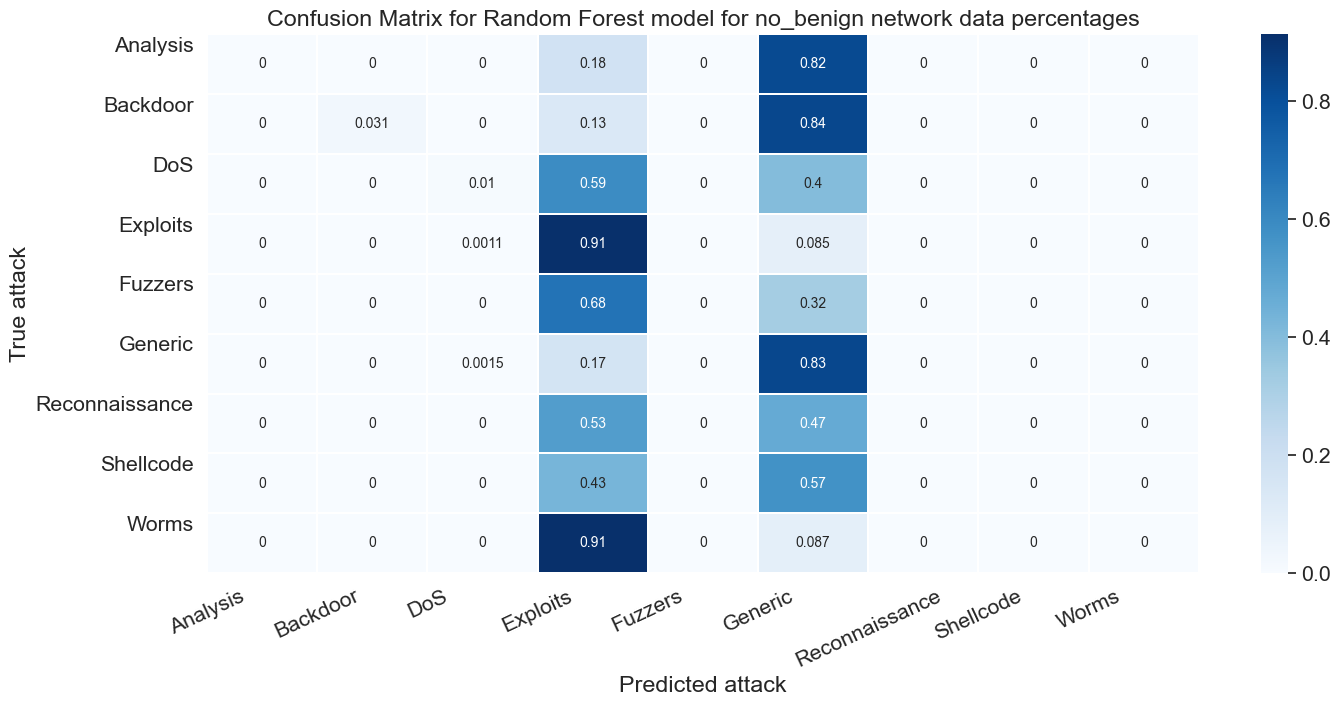

In [100]:
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Blues, linewidths=0.2)

# make plot look good
label_mapping2 #attack type encoding mapping
tick_marks = np.arange(len(label_mapping2))
tick_marks2 = tick_marks + 0.2
plt.xticks(tick_marks, label_mapping2, rotation=25)
plt.yticks(tick_marks2, label_mapping2, rotation=0)
plt.xlabel('Predicted attack')
plt.ylabel('True attack')
plt.title('Confusion Matrix for Random Forest model for no_benign network data percentages')
plt.show()

# <font color=blue>G1. Below is Random forest model with PCA no_benign data</font>

This one takes some time

In [101]:
# Create and train the Random Forest Classifier model
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train_PCA, y_train_PCA.values.ravel())


# Make predictions on the validation set
y_pred = rf_classifier.predict(X_val_PCA)

# Evaluate the model's accuracy
accuracy = accuracy_score(y_val_PCA.values.ravel(), y_pred.ravel())
print("Accuracy:", accuracy)

Accuracy: 0.6928


<font color=green>Compared with the full feature model, the 10 variable PCA data a bit worse (.77 vs .79 accuracy in one sample). PCA is not always a good solution for a data set , especially non linear classifier data.</font>

Test data

In [102]:
# Make predictions on the validation set
y_pred = rf_classifier.predict(X_test_PCA)

# Evaluate the model's accuracy
accuracy = accuracy_score(y_test_PCA.values.ravel(), y_pred.ravel())
print("Accuracy:", accuracy)

Accuracy: 0.6900444444444445


# 2nd model: Forward neural network implemented as an MLPClassifier

<font color=green>An MLP classifier or Multi-layer Perceptron classifier, is a type of feed forward neural network. It is a supervised machine learning model composed of many layers. This is optimal in situations where non-linear data needs to be classified (like determining attack type from network flow data). The input layer of the neural network is composed of nodes (neuron analogy) corresponding to each netflow feature in the data set. The output layer is composed of the classifications (9 attack types in my case) with an assigned probability. There are many 'hidden' layers in between the input and output layers which perform the learning computations. The feed foward aspect means that the processing of information only flows from input to output, there is no feedback from output to input or in the hidden layers. Feed foward has many advantages and disadvanges compared with feedback neural networks, but in this case I chose it because it is more effecient and faster in my case. I will validate it on both normalized and non normalized data.</font>

### MLPClassifier trained on non attack data

In [103]:
#get a subset of the data because this one takes a long time
FNN_df = datasample.sample(10000)
FNN_nobenign_df = no_benign_df.sample(10000) 

#Split the data into independent variables (X) and the target variable (y)
X = FNN_nobenign_df.drop(columns=['Attack'])  # Drop the target column to get the independent variables
y = FNN_nobenign_df['Attack']  # The target variable containing the 7 network attacks

In [104]:
# Split the data into training and testing sets
X_train, X_test_and_val, y_train, y_test_and_val = train_test_split(X, y, train_size = 0.7,random_state = 100)
X_val, X_test, y_val, y_test = train_test_split(X_test_and_val, y_test_and_val, test_size = 0.5, random_state = 100)


# Feature Scaling normalize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)


#### This is how I found the optimal epoch size. Commented out because it takes a long time.

In [105]:
#create an instance of MLP classifier
#mlp_classifier = MLPClassifier(hidden_layer_sizes=(50,), random_state=42)

#find best number of epochs, this takes a long time on non colab
#epochs_list = [100, 250, 500, 750, 1000]
#accuracy_scores = []

#find optimal epochs
#for epochs in epochs_list:
#    mlp_classifier.set_params(max_iter=epochs)
#    scores = cross_val_score(mlp_classifier, X_train_scaled, y_train, cv=5)
#    accuracy_scores.append(np.mean(scores))
#best_epochs = epochs_list[np.argmax(accuracy_scores)]
#print(f"The optimal number of epochs is: {best_epochs}")

In [106]:
# Initialize the MLPClassifier and train the model on non normalized data, max iter is the number of epochs

mlp_classifier = MLPClassifier(hidden_layer_sizes=(50, 26), activation='relu', random_state=42, max_iter=750)
mlp_classifier.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = mlp_classifier.predict(X_val)

# Make predictions with the normalized validation set
mlp_classifier = MLPClassifier(hidden_layer_sizes=(50, 26), activation='relu', random_state=42, max_iter=750)
mlp_classifier.fit(X_train_scaled, y_train)
y_pred_normalized = mlp_classifier.predict(X_val_scaled)

# Evaluate the model
print("normalized: ", accuracy_score(y_val, y_pred_normalized), " VS        Non normalized:",accuracy_score(y_val, y_pred))
print("normalized data:")

classification_report_output = classification_report(y_val, y_pred_normalized, zero_division=0)
confusion_mat = confusion_matrix(y_val, y_pred_normalized)

print("Accuracy:", accuracy_score(y_val, y_pred_normalized))
print("Classification Report:")
print(classification_report_output)
print("Confusion Matrix:")
print(confusion_mat)


normalized:  0.7526666666666667  VS        Non normalized: 0.3373333333333333
normalized data:
Accuracy: 0.7526666666666667
Classification Report:
              precision    recall  f1-score   support

           0       0.12      0.13      0.13        38
           1       0.23      0.08      0.12        38
           2       0.29      0.09      0.13        92
           3       0.77      0.82      0.80       491
           4       0.79      0.88      0.83       357
           5       0.80      0.81      0.80       256
           6       0.79      0.83      0.81       209
           7       0.87      0.87      0.87        15
           8       0.00      0.00      0.00         4

    accuracy                           0.75      1500
   macro avg       0.52      0.50      0.50      1500
weighted avg       0.72      0.75      0.73      1500

Confusion Matrix:
[[  5   0   2  13  10   5   3   0   0]
 [  9   3   1   6   6   5   8   0   0]
 [  8   2   8  39  17  12   5   0   1]
 [  9   3   6

<font color=green>The forward neural network did not perform as well as the random forest classifier but it was close. It had an overall lower accuracy and precision (macro), but it was still good. Next, I use the test data set rather than the validation set. It performed better with normalized data than non-normalized data.</font>

In [107]:
#normalize 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Make predictions on the test set
y_pred = mlp_classifier.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_report_output = classification_report(y_test, y_pred, zero_division=0)
confusion_mat = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report_output)
print("Confusion Matrix:")
print(confusion_mat)


Accuracy: 0.7473333333333333
Classification Report:
              precision    recall  f1-score   support

           0       0.23      0.21      0.22        33
           1       0.00      0.00      0.00        30
           2       0.17      0.06      0.09        79
           3       0.78      0.80      0.79       505
           4       0.78      0.86      0.82       359
           5       0.81      0.82      0.81       279
           6       0.73      0.79      0.76       198
           7       0.55      0.69      0.61        16
           8       0.00      0.00      0.00         1

    accuracy                           0.75      1500
   macro avg       0.45      0.47      0.46      1500
weighted avg       0.72      0.75      0.73      1500

Confusion Matrix:
[[  7   0   2  11   5   3   5   0   0]
 [  5   0   0   6   9   1   7   2   0]
 [  6   1   5  40  14   9   3   1   0]
 [  4   2  10 405  29  28  23   4   0]
 [  4   0   4  18 308   9  15   1   0]
 [  0   2   6  19  16 229   6 

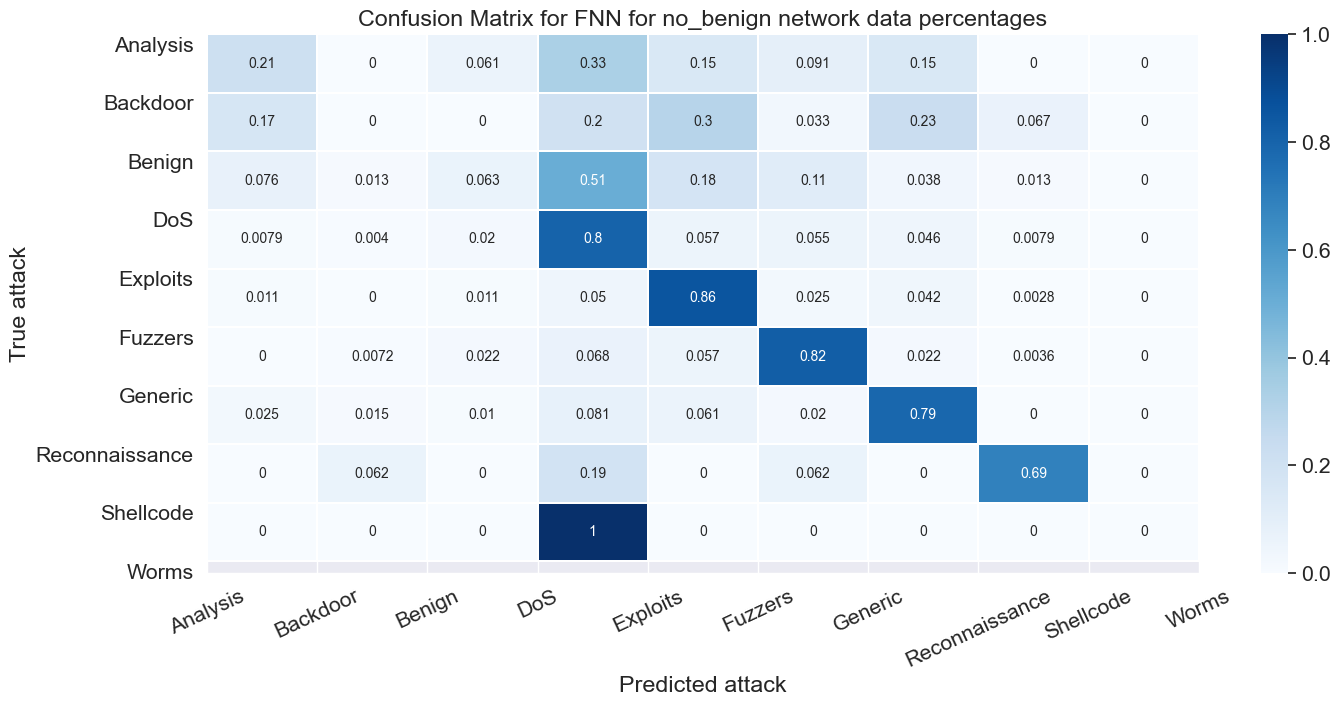

In [108]:
# Get and reshape confusion matrix data
confusion_mat = confusion_mat.astype('float') / confusion_mat.sum(axis=1)[:, np.newaxis]


# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(confusion_mat, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Blues, linewidths=0.2)

# make plot look good
label_mapping1 #attack type encoding mapping
tick_marks = np.arange(len(label_mapping1))
tick_marks2 = tick_marks + 0.2
plt.xticks(tick_marks, label_mapping1, rotation=25)
plt.yticks(tick_marks2, label_mapping1, rotation=0)
plt.xlabel('Predicted attack')
plt.ylabel('True attack')
plt.title('Confusion Matrix for FNN for no_benign network data percentages')
plt.show()

<font color=green>The model performed well on the testing data - almost as good as the validation data. The darker/higher density in the diagonal signifies correct predictions (true positives for a class type)</font>

## <font color=green>Now, I will reduce the data set by using chi-squared analysis to see if a reduced feature set leads to accuracy improvements</font>

#### First, create the reduced data set using chi squared

In [109]:
#init empty results
selected_features = []
p_values = []
chi2_values = []

# Compute chi-square statistic and p-values for each categorical feature
for cat_feature in FNN_nobenign_df.drop(columns=['Attack']).columns.to_list()[1:]:
    contingency_table = pd.crosstab(FNN_nobenign_df['Attack'], FNN_nobenign_df[cat_feature])
    chi2, p_value, _, _ = chi2_contingency(contingency_table)
    p_values.append(p_value)
    chi2_values.append(chi2)
    if p_value < 0.05:  #Significance level
        selected_features.append(cat_feature)

# Create a new dataset with only the selected features
chi_reduced_data = FNN_nobenign_df[selected_features + ['Attack']]
for i in range(len(FNN_nobenign_df.drop(columns=['Attack']).columns.to_list()[1:])):
    print(f"Feature: {FNN_nobenign_df.drop(columns=['Attack']).columns.to_list()[1:][i]}")
    print(f"Chi-square value: {chi2_values[i]}")
    print(f"P-value: {p_values[i]}")
    print("-------------------")

Feature: IPV4_SRC_ADDR
Chi-square value: 305.8298531077747
P-value: 1.1216887031383417e-50
-------------------
Feature: L4_SRC_PORT
Chi-square value: 54340.21940172722
P-value: 0.06714819174851214
-------------------
Feature: IPV4_DST_ADDR
Chi-square value: 1379.3829363039529
P-value: 6.79315018842571e-241
-------------------
Feature: L4_DST_PORT
Chi-square value: 35000.267469932296
P-value: 0.0
-------------------
Feature: PROTOCOL
Chi-square value: 9128.26333651433
P-value: 0.0
-------------------
Feature: L7_PROTO
Chi-square value: 4480.388694503876
P-value: 0.0
-------------------
Feature: IN_BYTES
Chi-square value: 37127.491329145545
P-value: 0.0
-------------------
Feature: IN_PKTS
Chi-square value: 6236.44549929871
P-value: 0.0
-------------------
Feature: OUT_BYTES
Chi-square value: 18325.130427700606
P-value: 4.300008695133251e-101
-------------------
Feature: OUT_PKTS
Chi-square value: 7455.4689513770645
P-value: 0.0
-------------------
Feature: TCP_FLAGS
Chi-square value: 67

## run the mlp on the chi squared set

In [110]:


#Split the data into independent variables (X) and the target variable (y)
X = chi_reduced_data.drop(columns=['Attack'])  # Drop the target column to get the independent variables
y = chi_reduced_data['Attack']  # The target variable containing the 7 network attacks

# Split the data into training and testing sets


X_train, X_test_and_val, y_train, y_test_and_val = train_test_split(X, y, train_size = 0.7,random_state = 100)
X_val, X_test, y_val, y_test = train_test_split(X_test_and_val, y_test_and_val, test_size = 0.5, random_state = 100)


# Feature Scaling normalize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


#create an instance of MLP classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100,), random_state=42)

#THIS TAKES A LONG TIME, ONLY NEED TO DO THIS ONCE TO FIND OPTIMAL VALUE

#find best number of epochs
#epochs_list = [750, 1000, 1500]
#accuracy_scores = []

#find optimal epochs
#for epochs in epochs_list:
 #   mlp_classifier.set_params(max_iter=epochs)
  #  scores = cross_val_score(mlp_classifier, X_train_scaled, y_train, cv=5)
   # accuracy_scores.append(np.mean(scores))
#best_epochs = epochs_list[np.argmax(accuracy_scores)]
#print(f"The optimal number of epochs is: {best_epochs}")



# Initialize the MLPClassifier and train the model on non normalized data, max iter is the number of epochs

#mlp_classifier = MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', solver='sgd',learning_rate = 'constant',learning_rate_init = 0.01,random_state=42, max_iter=750)
#mlp_classifier.fit(X_train, y_train)

# Make predictions on the validation set
#y_pred = mlp_classifier.predict(X_val)

# Make predictions with the normalized validation set
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', random_state=42, max_iter=500)
mlp_classifier.fit(X_train_scaled, y_train)
y_pred_normalized = mlp_classifier.predict(X_val_scaled)

# Evaluate the model
print("normalized: ", accuracy_score(y_val, y_pred_normalized))
print("normalized data:")

classification_report_output = classification_report(y_val, y_pred_normalized, zero_division=0)
confusion_mat = confusion_matrix(y_val, y_pred_normalized)

print("Accuracy:", accuracy_score(y_val, y_pred_normalized))
print("Classification Report:")
print(classification_report_output)
print("Confusion Matrix:")
print(confusion_mat)

normalized:  0.7426666666666667
normalized data:
Accuracy: 0.7426666666666667
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        38
           1       0.09      0.08      0.08        38
           2       0.15      0.11      0.13        92
           3       0.80      0.82      0.81       491
           4       0.90      0.84      0.87       357
           5       0.72      0.82      0.77       256
           6       0.70      0.84      0.77       209
           7       0.75      0.80      0.77        15
           8       0.00      0.00      0.00         4

    accuracy                           0.74      1500
   macro avg       0.46      0.48      0.47      1500
weighted avg       0.71      0.74      0.73      1500

Confusion Matrix:
[[  0   5  10   7   1  11   4   0   0]
 [  1   3   5   6   2  14   7   0   0]
 [  0   5  10  37  11  14  15   0   0]
 [  1   7  16 404  13  25  21   3   1]
 [  0   5  15  11 29

<font color=green>There is a slight improvement for the MLPClassifier similar in magnitude to the RFC improvment of 1% when using the reduce chi squared feature set. </font>

test set for normalized chi squared reduced set:

In [111]:
y_pred_normalized = mlp_classifier.predict(X_test_scaled)
# Evaluate the model
print("normalized: ", accuracy_score(y_test, y_pred_normalized))



normalized:  0.7553333333333333


# Bonus: 3rd model Support Vector Machine.

<font color=green>The SVM works well for classification problems by first dividing the data into hyperplanes that classify the data. Certain groupings of points represent classes. It then finds the best way to place a hyperplane through useful data that fit each type of class so that the difference between the points of a class is maximized.</font>

In [112]:

X = Is_Attack_Removed_df.drop(['Attack'], axis= 1)
y = Is_Attack_Removed_df['Attack']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the SVM model
SVMmodel = SVC(kernel='poly', degree=2)  # polynomial kernel
SVMmodel.fit(X_train, y_train)

y_train_pred = SVMmodel.predict(X_train)
# Make predictions on the test set
y_pred = SVMmodel.predict(X_test)

# Calculate accuracy
accuracyTrain = accuracy_score(y_train, y_train_pred)
accuracyTest = accuracy_score(y_test, y_pred)
print(f"Accuracy Train: {accuracyTrain:.2f}")
print(f"Accuracy Test: {accuracyTest:.2f}")


Accuracy Train: 0.96
Accuracy Test: 0.96


<font color=green>The training accuracy was quite good with this model and hyperparameters. The test accuracy suggests there was no over/under fitting. It does not perform as well as the random forest classifier, but it is close. It outperforms the MLPClassifier significantly with accuracy scores of 96% vs 75% </font>

# 9. Evaluation metrics

I used several different metrics to evaluate the different models. First is the mean squared error, which is the square of the difference between the predicted model value and the actual data value. It is squared to maintain posivity and it is more desireable to minimize this value to smaller values than the differences in the class values in my case. There is conflicting information on how useful this metric is for random forest classifiers as it is more useful for regression tasks in general. <BR><BR>Next, I used accuracy which shows the perecentage/ratio of correct predictions/classifications. My RFC models had good accuracy scores in the high .90s, while the MLPClassifier had less optimal values around .7. <BR><BR>R2 scores are more for linear data and how well the model fits the data, I didn't use it much since my data is not linear. <BR><BR>The next metric I used was called the f1 score which is composed of 2 other metrics precision and recall. Precision i the percentage of true positive classifications over both true and false positives. Highly precise models have low false positives. Recall is similar but is the percent of true positives found over all the actual positives. F1 score uses both these metrics to calculate a score between 0 and 1. Minimizing false positives and false negatives increases this score (higher f1 is better). I used weighted and macro averages to average the precision. Weighted average overrepresents some attack classes (benign), so macro average is a better metric between the two.<BR><BR>I used z scores for all the values in the data set to find outliers. Z score describes how many standard deviations from the mean each point is. 90% of data is within 2 standard deviations so I found outliers that had high Z scores. <BR><BR> I used Chi squared test along with p values to reduce features given to my model to improve effeciency and accuracy. This test finds how variables are associated with each other by using p values which show how likely the value is to be independent. Low p values under a chosen significance value have a higher chance of being related. <BR><BR> I used a confusion matrix to show how well my model performed with true positives and negatives, and false positives and negatives. It can be interpreted as how 'confused' the model is. In other words, how much it thought negatives were positive and positives were negative. Values along the diagonal (top left to bottom right) are situations where the model predicted the class (Attack type) correctly. Any other value off the diagonal is an incorrect prediction. This can be visualized with a heatmap to make it easier to visualize the performance; with darker values representing more predictions.

# <font color=red>10 [FINAL] Report Results [4 points]
1. Test both of your models and report the performance. Which is a better model?
2. Write a summary to your project aka summarise what you did in the project.
</font>

1.

The random forest classifier performed slightly better than the forward neural network MLPClassifier on when both were trained on the dataset that included benign data. In fact most of the subsets of the benign-included data performed well with both classifiers. The Benign label data was very useful and important for training to set a baseline of what normal, not malicious, network flow looks like. Both models performed better with normalized data, this help reduce the affect of outlier data reduced the scale of the data for more efficient processing. 

Comparatively, the random forest classifier outperformed the mlpclassifier, (one sample RFC accuracy: .985, while MLPC accuracy was .755). After researching the differences between the models, RFC are easier to use on non-linear data because of less hyperparameters, compared with MLPC which take more time to determine the optimal values of learning rate and activation functions. MLPC are also more likely to overfit data, although I did not see this between my training and testing results. I will detail how I used each model and which data sets I used below.

2

I chose the NF-UNSW-NB15-v2 data set create via NIDS at the University of Canaberra. The data is a combination of both synthetic and actual attacks on their network. The data set is composed of 45 features of network flow data. My goal is to use 44 of these features to predict the Attack feature that is associated with each row of data. The attack type is one of 10 values, 

Each feature contributes to the attack type in different ways and magnitude. Since the data set was so large, I only trained using subsets of the 2.39 Million rows. I created 2 initial sets: datasample and no_benign. No_benign is a subset which has no benign attack data. I wanted to compare models trained with and without a normal baseline. The total data set only has around 80000 non benign attack values to use.

I began by cleaning up the data by removing any null/NaN values and any negative/black/invalid values. I then removed any duplicated data so as not to overemphasize that row. I found that the benign attack data rows greatly outnumbered the other types:

I converted any floating point values to integers (this didn’t create any data loss problems) to keep things consistent for when I visualized the data. I converted the IP address data to unique 64 bit integer values manually rather than encoding them just to illustrate that is an alternative method for preprocessing. 

Next, I looked for any outlying data. Outliers have the potential to skew the model if there are enough of them. Removing outliers should be a decision based on standard deviation and quartiles. It would likely apply more to features that are continuous like packet size rather than features like protocol number which are discrete.
I began by looking at the general data sample statistics using describe to look at the standard deviations and IQR for each variable. Some variables like OUT_PKT had large variance and potentially a lot of outliers. I used 4 methods of outlier detection. The first was a box plot to visualize where most of the data was for a feature and how big the whiskers were fore the deviant values. I showed 2 plots for OUT_PKTS, the second plot better visualized the outlying values outside the whiskers. 
The next method was Z score, which represents how many standard deviations each value is from the mean. I showed how to filter outlier values using a z score threshold.
The third method was a scatter plot which showed the number of IN_BYTES for each given attack type. I plotted both data with and without benign values for comparison because it changed the y axis scale. 
The further method for outlier detection I used was called an Isolation forest. This clusters the data into discrete forest collections and identifies values that are not part of any forest. I visualized it using a scatterplot with x being the outliers and o being the ‘inliers.’ I created a new dataframe that has the outliers removed called datasample_cleaned which using a contamination of .02 value to remove the top 2% of outlier data and a threshold value of -.2 to choose which outliers to remove.
I used the calculated anomaly scores using an isolation forest to remove values that were not close to the main clusters.

I further prepared the data by changing some label names to make their purpose more clear and encoding features that string type to integers for processing, like ‘Attack.’ I also created a mapping variable to store how the attack type mapped to integers values 0 through 8 for future display.

For the training, validation, and test split I chose the standard training value of 70%, and 15%/15% for test and validation data sets.

I have many visualizations of the data throughout the project, but the formal data visualization section has a few interesting visualizations. I start with a standard bar chart to show the distribution of attack types. The first has benign data included so that the proportions are not very helpful. The second bar chart has the benign data removed and clearly shows the distribution of attack types. 
Finally, I created a correlation heatmap based on principle component analysis. To do this, I first had to calculate the correlation value between all of the features to the attack feature using scaling and PCA. Highly correlated values had a more deep red color. Features with positive corr values like Is_attack, Min/max TTL, and IP destination address were highly correlated with PCA values. I created an alternative data sample with 5 components from the no_benign data called pca_df. I used this with both models in the next section to improve performance.
##Modeling<BR>
The first model I chose was a random forest classifier. As mentioned earlier, it is a collection of many separate decision trees that each calculate models with associated probabilities and combined with weights. I used 4 different data sets for this model: benign included, a dataset with the 4 most important values removed , no_benign , and PCA_no_benign.
<BR>
Benign_included yielded an accuracies around .99 which is very good. The mean square error was also very low around .07. This is the square of the predicted minus the actual values on average. The R2 score was around .88 which is close to one, where the model matches data very well. I created and graphed a confusion matrix to show how the well the values matched the actual values, darker squares were more accurate with the ones on the diagonal being optimal.
The data set with the 4 most important (calculated) variables had was slightly less accurate but still good at around .98. 
<BR>
The data set without the NO benign network data performed significantly worse (C) than the others at approximately .79 accuracy. The confusion matrix graph showed more false positives in the top which makes sense since it did not have benign data to help it know this attack data was benign.  (D) I compared this data set with a similar set but with the outliers above a z score of 1 removed. This significantly improved the accuracy by around 7% in some samples. I compared this with the chi-squared (E1) reduced no_benign set and it had a slightly improved accuracy. This is because the total number of features has been reduced and the irrelavent features are no longer creating noise in the model.<BR>
I trained the model on just 1 important feature (E2) just to see how it did. It performed poorly but a bit better than I assumed. I chose MIN_IP_PKT_LEN, which was the top calculated important feature. The model had a .44 accuracy rate.

Next, I ran the model which I trained on all types attack data (F), on a test set that had no benign. I predicted that it would have a lot of false positives since all it knew was attack data and wasn’t familiar with benign data. I thought it would be accurate at predicting attacks, but it was very poor across the board. It predicted most attacks were generic attacks. The accuracy  was only .03 on average.

For the last RFC application (G), I ran the random forest model with a data set that was reduced using principal component analysis (PCA) to reduce the number of features. I first normalized the data using minmaxscaler and then ran PCA to generate eigenvalues to plot on the y axis with number of components on the x. This is called a Scree plot and the point at which the elbow curves to a straight line should be used as the number of principal components. I found this to occur at 10 components. Using this value on the no_benign data, the RFC returned an accuracy of .68. Comparing this PCA data with the regular no_benign RFC data of .98, shows that PCA did not help in this situation. I researched the possible reasons why this happens and found that PCA does not always work well non-linear data, also RFC handle high feature counts relatively well and reducing them might hinder the model of with more complex relationships.

 The second machine learning model I chose was a forward neural network classifier call a multi-layer perceptron classifier. It is a supervised model with a variable number of forwardly interacting layers of nodes that represent the features. The input layer has the same number of nodes as input features and the output layer has the same number of nodes as output classes (attack types in my case). Any hidden layers in between have a variable number of layers. The connections between nodes are assigned weights and activation functions. Forward propagation means that the movement between nodes/neurons is unidirectional between layers. I can choose the number of epochs/iterations for the model. I noticed at epochs of less than 500 it did not converge, so I added an algorithm to find ideal epochs over this value. I found that 750 epochs was best. The best accuracy I obtained was .75 for the validation data and .71 for the testing data. I performed chi squared analysis to reduce the feature count of independent variables and had an improve them of 1% in most cases. Features with low p-scores were selected as being more statistically predictive of 'Attack' scores. <BR><BR> The final machine learning model I chose was a support vector machine. At present, I only trained it on the full data set. It outperforms the MLPClassifier by 20% accuracy points in some samples on average. It trails behind the random forest classifier by around 4% accuracy on various samples I used. Therefore, I would choose the random forest classifier for this application with the data sets that had no benign values and outlying values removed with z scores above 1. I would also choose the SVM model. I might be able to improve the performance of the MLPclassifier if I tuned the hyperparameters.


# 11. Ethics Question


In response to week 3 ethics question concerning AI replacing writers and plagiarizing other works.

This is a very relevant issue at the moment because the Writer’s Guild of America is currently on strike for several issues including how AI can be used to write scripts for entertainment. Ironically, it has been said that the strike could actually make AI written scripts more prevalent, at least in the present, because there are no laws forbidding it currently and many writers are on strike. Although, many professionals are not impressed yet, like the Black Mirror creator mentioned in the linked article. The stories are coherent, but just boring rehashed ideas linked together. But, I believe as the technology advances, it will learn what audiences enjoy. So I do think the writers jobs are at risk. <BR><BR>
They are asking that the AI tools only be used to research. One of their points is that a lot of what LLM produces can be considered plagiarism. This is true since the models are based on partially copywritten ideas and entertainment. LLM at the moment don’t really create new material, so it’s similar to simply rearranging preexisting ideas. The writers guild is a labor group, and it’s one of the first to formally challenge AI and those who would use it to replace their labor. AI solutions have already replaced jobs for humans without creating an equal number of new ones at a similar skill level. It seems not everyone is benefiting from this technology as promised. In order to survive in most modern societies, you need to be gainfully employed and if a large amounts of jobs are being eliminated with no new jobs, many people will not survive. There likely needs to be significant changes in terms of social safeguards to preemptively plan for this rather than leaving people unskilled for the future to suffer for being force into bad circumstances because of technological change.
